### Import libraries

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import pickle
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

batch_time=500
niters=5000
test_freq=50

activations = {
    'relu':    nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu':     nn.ELU(),
    'tanh':    nn.Tanh(),
    'gelu':    nn.GELU(),
    'leaky_relu': nn.LeakyReLU()
}

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

from misc import preprocessing
_ = preprocessing()

/home/fil/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Import data

In [2]:
file = './data_1D_hypo_500real'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)
    
stress_t,stress_tdt,pl_strain_t,pl_strain_tdt,el_strain_t,el_strain_tdt,strain_t,strain_tdt,energy_t,energy_tdt,dissipation_rate_tdt = data

stress_t = np.expand_dims(stress_t,1)
stress_tdt = np.expand_dims(stress_tdt,1)
pl_strain_t = np.expand_dims(pl_strain_t,1)
pl_strain_tdt = np.expand_dims(pl_strain_tdt,1)
el_strain_t = np.expand_dims(el_strain_t,1)
el_strain_tdt = np.expand_dims(el_strain_tdt,1)
strain_t = np.expand_dims(strain_t,1)
strain_tdt = np.expand_dims(strain_tdt,1)
energy_t = np.expand_dims(energy_t,1)
energy_tdt = np.expand_dims(energy_tdt,1)
dissipation_rate_tdt = np.expand_dims(dissipation_rate_tdt,1)

dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dstrain_pl = pl_strain_tdt - pl_strain_t
dstrain_el = el_strain_tdt - el_strain_t

#### Split data in paths (batch_time step for each path)

In [3]:
strain_t = np.reshape(strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
strain_tdt = np.reshape(strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain = np.reshape(dstrain,(-1,batch_time,1),order='C')[:,:,:,None]

pl_strain_t = np.reshape(pl_strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
pl_strain_tdt = np.reshape(pl_strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain_pl = np.reshape(dstrain_pl,(-1,batch_time,1),order='C')[:,:,:,None]

el_strain_t = np.reshape(el_strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
el_strain_tdt = np.reshape(el_strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain_el = np.reshape(dstrain_el,(-1,batch_time,1),order='C')[:,:,:,None]

stress_t = np.reshape(stress_t,(-1,batch_time,1),order='C')[:,:,:,None]
stress_tdt = np.reshape(stress_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstress = np.reshape(dstress,(-1,batch_time,1),order='C')[:,:,:,None]

energy_t = np.reshape(energy_t,(-1,batch_time,1),order='C')[:,:,:,None]
energy_tdt = np.reshape(energy_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dissipation_rate_tdt = np.reshape(dissipation_rate_tdt,(-1,batch_time,1),order='C')[:,:,:,None]

data_size = strain_t.shape[0]

#### Split into training, validation, and test sets

In [4]:
train_percentage = .1

ntrain = int(round(data_size * train_percentage))
nval = int(round(data_size * 0.5 *(1.- train_percentage)))
ntest = nval

print("Number of samples: ", data_size)
print("Training samples : ", ntrain)
print("Validation samples : ", nval)
print("Test samples : ", ntest)
print("Total : ", ntest + nval + ntrain)

Number of samples:  20
Training samples :  2
Validation samples :  9
Test samples :  9
Total :  20


In [5]:
strain_t_tv,strain_t_test = _.slice_data(strain_t,ntrain,nval)
strain_tdt_tv,strain_tdt_test = _.slice_data(strain_tdt,ntrain,nval)
pl_strain_t_tv,pl_strain_t_test = _.slice_data(pl_strain_t,ntrain,nval)
pl_strain_tdt_tv,pl_strain_tdt_test = _.slice_data(pl_strain_tdt,ntrain,nval)
dstrain_tv,dstrain_test = _.slice_data(dstrain,ntrain,nval)
dstrain_pl_tv,dstrain_pl_test = _.slice_data(dstrain_pl,ntrain,nval)

stress_t_tv,stress_t_test = _.slice_data(stress_t,ntrain,nval)
stress_tdt_tv,stress_tdt_test = _.slice_data(stress_tdt,ntrain,nval)
dstress_tv,dstress_test = _.slice_data(dstress,ntrain,nval)

energy_t_tv,energy_t_test = _.slice_data(energy_t,ntrain,nval)
energy_tdt_tv,energy_tdt_test = _.slice_data(energy_tdt,ntrain,nval)
dissipation_rate_tdt_tv,dissipation_rate_tdt_test = _.slice_data(dissipation_rate_tdt,ntrain,nval)

#### Compute statistics of the data (for normalization)

In [6]:
prm_e = _.GetParams(strain_tdt_tv)
prm_de = _.GetParams(dstrain_tv)

prm_s = _.GetParams(stress_tdt_tv)
prm_ds = _.GetParams(dstress_tv)

prm_z = _.GetParams(pl_strain_tdt_tv)
prm_dz = _.GetParams(dstrain_pl_tv)

prm_f = _.GetParams(energy_tdt_tv)
prm_d = _.GetParams(dissipation_rate_tdt_tv)

### TANN 

In [7]:
class TANN(nn.Module):

    def __init__(self,params_z,params_f,dtype=torch.float32):
        super(TANN, self).__init__()
        
        self.dtype = dtype
        i_NNz,o_NNz,h_NNz,act_NNz = params_z
        i_NNf,o_NNf,h_NNf,act_NNf = params_f
        
        
        self.NNz = self.constructor(i_NNz,
                                    o_NNz,
                                    h_NNz,
                                    act_NNz)
        
        self.NNf = self.constructor(i_NNf,
                                    o_NNf,
                                    h_NNf,
                                    act_NNf)
        
    def constructor(self, i_dim, o_dim, h_dim, act):
        dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers
    
    def Normalize(self,inputs,prm):
        '''
        Normalize features
        :inputs : data
        :prm : normalization parameters
        '''
        return torch.divide(torch.add(inputs, -prm[1]), prm[0])
    
    def DeNormalize(self,outputs,prm):
        '''
        Denormalize features
        :output : dimensionless data
        :prm : normalization parameters
        '''
        return torch.add(torch.multiply(outputs, prm[0]), prm[1])
    
    def forward(self,inp):
        inp = torch.autograd.Variable(inp,requires_grad=True)
        n_strain_t, n_pl_strain_t, n_dstrain = inp[:,0,None],inp[:,1,None],inp[:,2,None]
        
        # Normalize
        strain_t = self.DeNormalize(n_strain_t,prm_e)
        pl_strain_t = self.DeNormalize(n_pl_strain_t,prm_z)
        dstrain = self.DeNormalize(n_dstrain,prm_de)
        strain_tdt = strain_t+dstrain
        N_strain_tdt = self.Normalize(strain_tdt,prm_e)
        
        
        # Predict evolution law
        npl_dstrain = self.NNz(torch.cat((n_strain_t,n_pl_strain_t,n_dstrain),1))
        pl_dstrain = self.DeNormalize(npl_dstrain,prm_dz)
        pl_strain_tdt = pl_dstrain+pl_strain_t
        n_pl_strain_tdt = self.Normalize(pl_strain_tdt,prm_z)
        
        
        # Predict energy, stress, and dissipation rate
        n_energy_tdt = self.NNf(torch.cat((n_pl_strain_tdt,N_strain_tdt),1))
        energy_tdt = self.DeNormalize(n_energy_tdt,prm_f)
        
        
        
        # Stress
        stress_tdt = torch.autograd.grad(energy_tdt,strain_tdt,
                                     grad_outputs=torch.ones_like(strain_tdt),
                                     retain_graph=True,
                                     create_graph=True)[0]
        n_stress_tdt = self.Normalize(stress_tdt,prm_s)
        
        # Dissipation rate
        thermo_stress = -torch.autograd.grad(energy_tdt,pl_strain_tdt,
                                     grad_outputs=torch.ones_like(pl_strain_tdt),
                                     retain_graph=True,
                                     create_graph=True)[0]
        dissipation_tdt = thermo_stress*pl_dstrain
        n_dissipation_tdt = self.Normalize(dissipation_tdt,prm_d)
        
        return torch.cat((npl_dstrain,n_energy_tdt,n_stress_tdt,n_dissipation_tdt),1)

In [8]:
dtype=torch.float64
NNf_params = [3,1,[32,32,32],'relu']
NNu_params = [2,1,[144,144],'gelu']
TANNnet = TANN(NNf_params,NNu_params,dtype).to(device)
TANNnet.to(torch.double)

TANN(
  (NNz): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNf): Sequential(
    (0): Linear(in_features=2, out_features=144, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=144, out_features=144, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=144, out_features=1, bias=True)
  )
)

### Normalize datasets and assemble inputs and outputs

In [9]:
strain_t_tv = TANNnet.Normalize(torch.tensor(strain_t_tv),prm_e)
strain_tdt_tv = TANNnet.Normalize(torch.tensor(strain_tdt_tv),prm_e)
pl_strain_t_tv = TANNnet.Normalize(torch.tensor(pl_strain_t_tv),prm_z)
pl_strain_tdt_tv = TANNnet.Normalize(torch.tensor(pl_strain_tdt_tv),prm_z)
stress_tdt_tv = TANNnet.Normalize(torch.tensor(stress_tdt_tv),prm_s)

energy_tdt_tv = TANNnet.Normalize(torch.tensor(energy_tdt_tv),prm_f)
dissipation_rate_tdt_tv = TANNnet.Normalize(torch.tensor(dissipation_rate_tdt_tv),prm_d)

dstrain_tv = TANNnet.Normalize(torch.tensor(dstrain_tv),prm_de)
dstrain_pl_tv = TANNnet.Normalize(torch.tensor(dstrain_pl_tv),prm_dz)
dstress_tv = TANNnet.Normalize(torch.tensor(dstress_tv),prm_ds)

strain_t_test = TANNnet.Normalize(torch.tensor(strain_t_test),prm_e)
strain_tdt_test = TANNnet.Normalize(torch.tensor(strain_tdt_test),prm_e)
pl_strain_t_test = TANNnet.Normalize(torch.tensor(pl_strain_t_test),prm_z)
pl_strain_tdt_test = TANNnet.Normalize(torch.tensor(pl_strain_tdt_test),prm_z)
stress_tdt_test = TANNnet.Normalize(torch.tensor(stress_tdt_test),prm_s)

energy_tdt_test = TANNnet.Normalize(torch.tensor(energy_tdt_test),prm_f)
dissipation_rate_tdt_test = TANNnet.Normalize(torch.tensor(dissipation_rate_tdt_test),prm_d)

dstrain_test = TANNnet.Normalize(torch.tensor(dstrain_test),prm_de)
dstrain_pl_test = TANNnet.Normalize(torch.tensor(dstrain_pl_test),prm_dz)
dstress_test = TANNnet.Normalize(torch.tensor(dstress_test),prm_ds)


In [10]:
input_tv = torch.cat((strain_t_tv,pl_strain_t_tv,dstrain_tv),-1).to(device)
output_tv = torch.cat((dstrain_pl_tv,energy_tdt_tv,stress_tdt_tv,dissipation_rate_tdt_tv),-1).to(device)

input_test = torch.cat((strain_t_test,pl_strain_t_test,dstrain_test),-1).to(device)
output_test = torch.cat((dstrain_pl_test,energy_tdt_test,stress_tdt_test,dissipation_rate_tdt_test),-1).to(device)

### Training 

1  --  8.969295
2  --  8.9417305
3  --  8.918713
4  --  8.895674
5  --  8.872462
6  --  8.849336
7  --  8.826561
8  --  8.804347
9  --  8.782856
10  --  8.762206
11  --  8.742482
12  --  8.723734
13  --  8.705994
14  --  8.689267
15  --  8.673542
16  --  8.658784
17  --  8.644961
18  --  8.632026
19  --  8.61993
20  --  8.608617
21  --  8.598026
22  --  8.588106
23  --  8.578808
24  --  8.570087
25  --  8.561901
26  --  8.554187
27  --  8.546889
28  --  8.53997
29  --  8.53337
30  --  8.527045
31  --  8.52096
32  --  8.515073
33  --  8.50935
34  --  8.503768
35  --  8.498298
36  --  8.492911
37  --  8.487589
38  --  8.482313
39  --  8.477062
40  --  8.471812
41  --  8.4665575
42  --  8.4612875
43  --  8.456002
44  --  8.45071
45  --  8.445401
46  --  8.440064
47  --  8.434685
48  --  8.42925
49  --  8.423761
50  --  8.418221


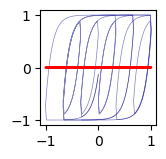

51  --  8.412631
52  --  8.4069805
53  --  8.401278
54  --  8.395521
55  --  8.389714
56  --  8.383844
57  --  8.377906
58  --  8.371901
59  --  8.365826
60  --  8.359677
61  --  8.353441
62  --  8.347108
63  --  8.340719
64  --  8.334279
65  --  8.327769
66  --  8.321174
67  --  8.31443
68  --  8.307524
69  --  8.300516
70  --  8.293411
71  --  8.286239
72  --  8.279011
73  --  8.271731
74  --  8.264387
75  --  8.256977
76  --  8.249516
77  --  8.24201
78  --  8.234457
79  --  8.226844
80  --  8.219189
81  --  8.211505
82  --  8.203798
83  --  8.19606
84  --  8.188278
85  --  8.18045
86  --  8.172581
87  --  8.164675
88  --  8.156747
89  --  8.148832
90  --  8.140934
91  --  8.133046
92  --  8.125155
93  --  8.11726
94  --  8.109358
95  --  8.101444
96  --  8.0935135
97  --  8.0855665
98  --  8.077606
99  --  8.06966
100  --  8.061746


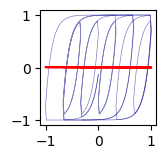

101  --  8.053836
102  --  8.045927
103  --  8.038022
104  --  8.030124
105  --  8.022232
106  --  8.014353
107  --  8.006489
108  --  7.998659
109  --  7.9908657
110  --  7.9830947
111  --  7.975344
112  --  7.967608
113  --  7.9598823
114  --  7.9521694
115  --  7.9444737
116  --  7.9368
117  --  7.9291444
118  --  7.921514
119  --  7.913925
120  --  7.9063935
121  --  7.898909
122  --  7.891469
123  --  7.8840675
124  --  7.876717
125  --  7.869414
126  --  7.86216
127  --  7.854958
128  --  7.8478217
129  --  7.84075
130  --  7.8337584
131  --  7.8268447
132  --  7.820001
133  --  7.8132215
134  --  7.8065085
135  --  7.799857
136  --  7.7932677
137  --  7.7867446
138  --  7.780289
139  --  7.7739015
140  --  7.7675805
141  --  7.7613277
142  --  7.7551417
143  --  7.7490244
144  --  7.7429733
145  --  7.7369905
146  --  7.7310805
147  --  7.7252483
148  --  7.719501
149  --  7.7138324
150  --  7.708242


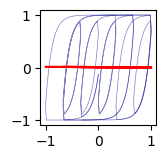

151  --  7.702732
152  --  7.697302
153  --  7.691945
154  --  7.686662
155  --  7.6814528
156  --  7.6763167
157  --  7.671253
158  --  7.666264
159  --  7.6613464
160  --  7.6565037
161  --  7.651734
162  --  7.647037
163  --  7.642416
164  --  7.6378694
165  --  7.6333976
166  --  7.628997
167  --  7.6246667
168  --  7.620407
169  --  7.616217
170  --  7.6121016
171  --  7.608063
172  --  7.6041045
173  --  7.6002283
174  --  7.596429
175  --  7.592703
176  --  7.5890503
177  --  7.5854664
178  --  7.58195
179  --  7.578503
180  --  7.5751243
181  --  7.5718136
182  --  7.568573
183  --  7.5654006
184  --  7.562296
185  --  7.559262
186  --  7.556297
187  --  7.553405
188  --  7.550585
189  --  7.5478354
190  --  7.5451565
191  --  7.5425463
192  --  7.5399995
193  --  7.5375147
194  --  7.5350885
195  --  7.5327215
196  --  7.5304112
197  --  7.5281563
198  --  7.5259566
199  --  7.5238066
200  --  7.521705


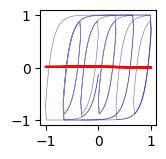

201  --  7.519648
202  --  7.5176334
203  --  7.5156636
204  --  7.513738
205  --  7.5118494
206  --  7.5099983
207  --  7.508181
208  --  7.5063996
209  --  7.504654
210  --  7.502933
211  --  7.501237
212  --  7.499568
213  --  7.497919
214  --  7.4962807
215  --  7.494643
216  --  7.493015
217  --  7.4914126
218  --  7.4898477
219  --  7.488327
220  --  7.486825
221  --  7.4853454
222  --  7.483904
223  --  7.482496
224  --  7.4811144
225  --  7.479755
226  --  7.478412
227  --  7.477094
228  --  7.4758053
229  --  7.4745493
230  --  7.4733267
231  --  7.472142
232  --  7.470985
233  --  7.469846
234  --  7.4687247
235  --  7.4676204
236  --  7.466531
237  --  7.465456
238  --  7.464396
239  --  7.463353
240  --  7.462326
241  --  7.461314
242  --  7.4603176
243  --  7.459337
244  --  7.458371
245  --  7.4574165
246  --  7.4564686
247  --  7.455527
248  --  7.45459
249  --  7.453657
250  --  7.4527287


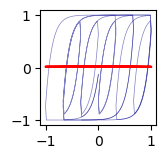

251  --  7.4518056
252  --  7.4508862
253  --  7.4499726
254  --  7.4490643
255  --  7.4481597
256  --  7.4472604
257  --  7.4463673
258  --  7.44548
259  --  7.444596
260  --  7.443713
261  --  7.4428344
262  --  7.4419556
263  --  7.441076
264  --  7.4401965
265  --  7.4393177
266  --  7.438439
267  --  7.4375587
268  --  7.436679
269  --  7.435799
270  --  7.4349184
271  --  7.4340353
272  --  7.433152
273  --  7.432269
274  --  7.431384
275  --  7.4304976
276  --  7.4296093
277  --  7.4287186
278  --  7.4278235
279  --  7.426926
280  --  7.426024
281  --  7.425112
282  --  7.424197
283  --  7.4232793
284  --  7.422358
285  --  7.4214325
286  --  7.4205017
287  --  7.419565
288  --  7.418624
289  --  7.4176836
290  --  7.4167495
291  --  7.4158244
292  --  7.414899
293  --  7.4139714
294  --  7.4130416
295  --  7.4121084
296  --  7.411173
297  --  7.4102354
298  --  7.409296
299  --  7.4083548
300  --  7.407411


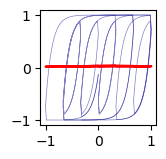

301  --  7.406464
302  --  7.4055142
303  --  7.404562
304  --  7.403606
305  --  7.402645
306  --  7.4016805
307  --  7.4007125
308  --  7.399742
309  --  7.398767
310  --  7.397786
311  --  7.396801
312  --  7.3958106
313  --  7.394816
314  --  7.393818
315  --  7.392817
316  --  7.391813
317  --  7.3908057
318  --  7.3897943
319  --  7.3887796
320  --  7.3877616
321  --  7.3867393
322  --  7.3857136
323  --  7.384685
324  --  7.383654
325  --  7.3826203
326  --  7.381584
327  --  7.380544
328  --  7.3795023
329  --  7.3784575
330  --  7.377409
331  --  7.376358
332  --  7.3753037
333  --  7.374247
334  --  7.373188
335  --  7.372126
336  --  7.3710613
337  --  7.3699937
338  --  7.3689227
339  --  7.367848
340  --  7.3667703
341  --  7.3656883
342  --  7.3646035
343  --  7.3635154
344  --  7.3624244
345  --  7.3613296
346  --  7.3602314
347  --  7.3591304
348  --  7.358026
349  --  7.356918
350  --  7.355806


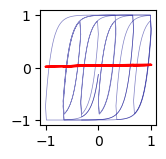

351  --  7.3546915
352  --  7.353573
353  --  7.3524494
354  --  7.351323
355  --  7.350194
356  --  7.3490615
357  --  7.347925
358  --  7.3467855
359  --  7.345642
360  --  7.3444953
361  --  7.343345
362  --  7.3421907
363  --  7.3410325
364  --  7.33987
365  --  7.3387046
366  --  7.3375344
367  --  7.3363605
368  --  7.335184
369  --  7.334005
370  --  7.332822
371  --  7.3316355
372  --  7.3304462
373  --  7.329254
374  --  7.328058
375  --  7.3268585
376  --  7.325657
377  --  7.3244524
378  --  7.3232446
379  --  7.3220344
380  --  7.3208213
381  --  7.319605
382  --  7.318387
383  --  7.3171663
384  --  7.3159432
385  --  7.314718
386  --  7.3134885
387  --  7.3122554
388  --  7.3110194
389  --  7.309777
390  --  7.3085303
391  --  7.3072786
392  --  7.306023
393  --  7.304762
394  --  7.3034935
395  --  7.302222
396  --  7.300942
397  --  7.299654
398  --  7.2983594
399  --  7.2970595
400  --  7.2957544


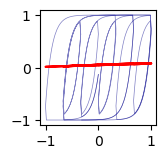

401  --  7.294447
402  --  7.29314
403  --  7.2918363
404  --  7.2905383
405  --  7.289247
406  --  7.287963
407  --  7.2866793
408  --  7.285396
409  --  7.284112
410  --  7.282828
411  --  7.2815423
412  --  7.2802567
413  --  7.2789702
414  --  7.277682
415  --  7.2763944
416  --  7.2751064
417  --  7.2738175
418  --  7.2725277
419  --  7.271237
420  --  7.2699447
421  --  7.2686524
422  --  7.2673583
423  --  7.2660623
424  --  7.2647657
425  --  7.2634673
426  --  7.2621665
427  --  7.260866
428  --  7.2595634
429  --  7.2582583
430  --  7.2569513
431  --  7.255641
432  --  7.2543287
433  --  7.2530155
434  --  7.2517004
435  --  7.250386
436  --  7.249069
437  --  7.2477484
438  --  7.246426
439  --  7.245104
440  --  7.243778
441  --  7.24245
442  --  7.24112
443  --  7.239788
444  --  7.2384534
445  --  7.2371163
446  --  7.235779
447  --  7.234438
448  --  7.233095
449  --  7.2317495
450  --  7.2304015


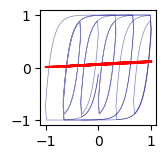

451  --  7.2290506
452  --  7.2276974
453  --  7.2263412
454  --  7.2249823
455  --  7.22362
456  --  7.2222567
457  --  7.220889
458  --  7.2195177
459  --  7.218146
460  --  7.21677
461  --  7.215391
462  --  7.2140083
463  --  7.212625
464  --  7.2112365
465  --  7.209846
466  --  7.2084527
467  --  7.207056
468  --  7.205656
469  --  7.204252
470  --  7.202846
471  --  7.201435
472  --  7.200021
473  --  7.1986017
474  --  7.1971807
475  --  7.1957555
476  --  7.194325
477  --  7.1928926
478  --  7.1914544
479  --  7.1900134
480  --  7.1885676
481  --  7.1871166
482  --  7.185663
483  --  7.184203
484  --  7.1827383
485  --  7.181271
486  --  7.179796
487  --  7.1783195
488  --  7.176835
489  --  7.1753483
490  --  7.1738534
491  --  7.1723547
492  --  7.1708508
493  --  7.1693406
494  --  7.1678247
495  --  7.166305
496  --  7.1647778
497  --  7.163247
498  --  7.16171
499  --  7.160167
500  --  7.1586185


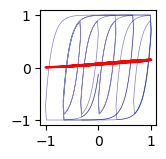

501  --  7.157064
502  --  7.1555047
503  --  7.153939
504  --  7.1523666
505  --  7.1507874
506  --  7.149202
507  --  7.1476088
508  --  7.1460094
509  --  7.144402
510  --  7.1427875
511  --  7.1411643
512  --  7.139536
513  --  7.1378984
514  --  7.136254
515  --  7.1346006
516  --  7.1329403
517  --  7.131272
518  --  7.129595
519  --  7.1279087
520  --  7.1262155
521  --  7.1245112
522  --  7.1228013
523  --  7.1210804
524  --  7.1193495
525  --  7.1176105
526  --  7.115861
527  --  7.1141024
528  --  7.1123333
529  --  7.110554
530  --  7.1087637
531  --  7.106964
532  --  7.1051526
533  --  7.10333
534  --  7.101494
535  --  7.099644
536  --  7.09778
537  --  7.095911
538  --  7.094035
539  --  7.0921483
540  --  7.090252
541  --  7.088342
542  --  7.086422
543  --  7.084488
544  --  7.082542
545  --  7.0805845
546  --  7.078612
547  --  7.0766287
548  --  7.0746307
549  --  7.07262
550  --  7.0705953


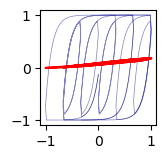

551  --  7.0685563
552  --  7.0665026
553  --  7.0644364
554  --  7.0623546
555  --  7.060258
556  --  7.058146
557  --  7.0560203
558  --  7.053878
559  --  7.051722
560  --  7.0495486
561  --  7.04736
562  --  7.045154
563  --  7.0429316
564  --  7.040692
565  --  7.0384345
566  --  7.0361614
567  --  7.033867
568  --  7.0315566
569  --  7.0292253
570  --  7.026872
571  --  7.024499
572  --  7.0221024
573  --  7.019679
574  --  7.017228
575  --  7.014764
576  --  7.012286
577  --  7.0097914
578  --  7.0072813
579  --  7.0047555
580  --  7.002216
581  --  6.9996543
582  --  6.99707
583  --  6.994463
584  --  6.991834
585  --  6.9891787
586  --  6.9865003
587  --  6.983796
588  --  6.9810643
589  --  6.9783125
590  --  6.9755416
591  --  6.9727497
592  --  6.969935
593  --  6.967099
594  --  6.9642396
595  --  6.961356
596  --  6.9584475
597  --  6.955515
598  --  6.952553
599  --  6.9495673
600  --  6.9465528


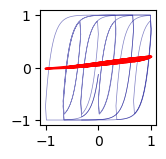

601  --  6.943514
602  --  6.940447
603  --  6.937351
604  --  6.934227
605  --  6.931076
606  --  6.927895
607  --  6.9246855
608  --  6.921447
609  --  6.918176
610  --  6.9148774
611  --  6.911547
612  --  6.908186
613  --  6.904794
614  --  6.9013705
615  --  6.897916
616  --  6.894426
617  --  6.8909054
618  --  6.8873496
619  --  6.8837605
620  --  6.880139
621  --  6.8764787
622  --  6.872788
623  --  6.8690586
624  --  6.8652945
625  --  6.861492
626  --  6.857654
627  --  6.8537807
628  --  6.849863
629  --  6.845914
630  --  6.8419223
631  --  6.8378925
632  --  6.833822
633  --  6.829711
634  --  6.825562
635  --  6.8213687
636  --  6.8171353
637  --  6.8128567
638  --  6.80854
639  --  6.804176
640  --  6.799769
641  --  6.7953196
642  --  6.79082
643  --  6.7862797
644  --  6.7816925
645  --  6.7770557
646  --  6.772374
647  --  6.7676454
648  --  6.7628627
649  --  6.7580366
650  --  6.753159


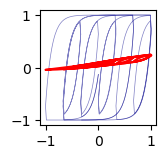

651  --  6.7482305
652  --  6.74325
653  --  6.73822
654  --  6.7331376
655  --  6.727999
656  --  6.722812
657  --  6.7175665
658  --  6.712267
659  --  6.7069087
660  --  6.7015014
661  --  6.69603
662  --  6.690508
663  --  6.684925
664  --  6.6792827
665  --  6.67358
666  --  6.6678176
667  --  6.6619935
668  --  6.656108
669  --  6.650158
670  --  6.6441483
671  --  6.6380715
672  --  6.6319323
673  --  6.625723
674  --  6.6194496
675  --  6.613106
676  --  6.6066966
677  --  6.6002164
678  --  6.5936646
679  --  6.5870385
680  --  6.580339
681  --  6.5735583
682  --  6.5667024
683  --  6.559767
684  --  6.5527453
685  --  6.545641
686  --  6.538454
687  --  6.531179
688  --  6.5238214
689  --  6.516379
690  --  6.508849
691  --  6.501238
692  --  6.493542
693  --  6.485765
694  --  6.4779015
695  --  6.4699526
696  --  6.461911
697  --  6.453794
698  --  6.4455943
699  --  6.437301
700  --  6.428922


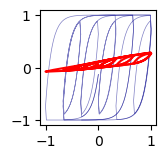

701  --  6.420456
702  --  6.4118996
703  --  6.4032483
704  --  6.3945026
705  --  6.3856616
706  --  6.3767242
707  --  6.3676896
708  --  6.3585525
709  --  6.349313
710  --  6.3399706
711  --  6.330526
712  --  6.3209724
713  --  6.311317
714  --  6.301553
715  --  6.2916794
716  --  6.281693
717  --  6.2715974
718  --  6.261386
719  --  6.251064
720  --  6.240623
721  --  6.230066
722  --  6.219392
723  --  6.208594
724  --  6.197678
725  --  6.186633
726  --  6.175468
727  --  6.1641736
728  --  6.1527557
729  --  6.1412063
730  --  6.1295295
731  --  6.1177163
732  --  6.105772
733  --  6.0936933
734  --  6.081475
735  --  6.069119
736  --  6.0566235
737  --  6.04399
738  --  6.0312114
739  --  6.018292
740  --  6.005229
741  --  5.9920177
742  --  5.978656
743  --  5.965145
744  --  5.9514837
745  --  5.9376707
746  --  5.923705
747  --  5.9095807
748  --  5.8953
749  --  5.880859
750  --  5.8662596


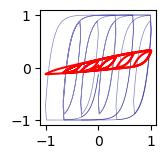

751  --  5.851498
752  --  5.8365765
753  --  5.821491
754  --  5.806238
755  --  5.790815
756  --  5.7752233
757  --  5.7594624
758  --  5.7435293
759  --  5.7274184
760  --  5.711136
761  --  5.6946745
762  --  5.6780324
763  --  5.661209
764  --  5.6442027
765  --  5.627014
766  --  5.6096478
767  --  5.592088
768  --  5.5743427
769  --  5.5564137
770  --  5.5383024
771  --  5.520003
772  --  5.5015216
773  --  5.4828553
774  --  5.464
775  --  5.4449573
776  --  5.425724
777  --  5.4062996
778  --  5.3866844
779  --  5.366879
780  --  5.3468738
781  --  5.3266754
782  --  5.306285
783  --  5.2856984
784  --  5.264914
785  --  5.243935
786  --  5.2227564
787  --  5.2013826
788  --  5.179808
789  --  5.158037
790  --  5.1360626
791  --  5.113896
792  --  5.0915236
793  --  5.0689554
794  --  5.046183
795  --  5.023214
796  --  5.0000424
797  --  4.9766717
798  --  4.953104
799  --  4.929337
800  --  4.905372


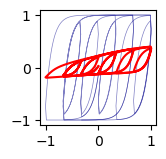

801  --  4.881212
802  --  4.8568573
803  --  4.832309
804  --  4.807556
805  --  4.782607
806  --  4.757463
807  --  4.7321286
808  --  4.7066035
809  --  4.6808777
810  --  4.654975
811  --  4.6288614
812  --  4.602583
813  --  4.5761147
814  --  4.549464
815  --  4.522637
816  --  4.49563
817  --  4.468444
818  --  4.441087
819  --  4.4135528
820  --  4.385854
821  --  4.357993
822  --  4.3299613
823  --  4.3017726
824  --  4.2734275
825  --  4.2449293
826  --  4.216284
827  --  4.1874857
828  --  4.15855
829  --  4.1294737
830  --  4.10027
831  --  4.0709343
832  --  4.041476
833  --  4.0118966
834  --  3.982193
835  --  3.9523761
836  --  3.9224432
837  --  3.8924003
838  --  3.862255
839  --  3.8320043
840  --  3.8016567
841  --  3.771214
842  --  3.740683
843  --  3.710074
844  --  3.6793864
845  --  3.6486247
846  --  3.6177948
847  --  3.5869014
848  --  3.5559514
849  --  3.5249453
850  --  3.4938927


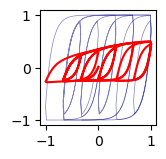

851  --  3.4627903
852  --  3.4316502
853  --  3.4004753
854  --  3.3692708
855  --  3.3380444
856  --  3.306794
857  --  3.275525
858  --  3.2442381
859  --  3.2129376
860  --  3.1816232
861  --  3.1503036
862  --  3.1189816
863  --  3.0876532
864  --  3.056299
865  --  3.0249546
866  --  2.9936352
867  --  2.962331
868  --  2.9310555
869  --  2.8998046
870  --  2.8686419
871  --  2.8376224
872  --  2.8067703
873  --  2.7760313
874  --  2.7453706
875  --  2.7147987
876  --  2.6843154
877  --  2.6539254
878  --  2.6236353
879  --  2.5934315
880  --  2.5633209
881  --  2.533322
882  --  2.503435
883  --  2.473665
884  --  2.4439957
885  --  2.414418
886  --  2.3849351
887  --  2.3555481
888  --  2.3263228
889  --  2.2972846
890  --  2.2684124
891  --  2.2397041
892  --  2.2111847
893  --  2.1828482
894  --  2.154677
895  --  2.1266952
896  --  2.098902
897  --  2.0713084
898  --  2.0439134
899  --  2.016709
900  --  1.9896905


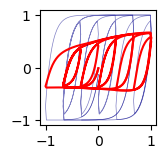

901  --  1.9628778
902  --  1.936262
903  --  1.9098531
904  --  1.8836323
905  --  1.8576182
906  --  1.831792
907  --  1.8061633
908  --  1.7807585
909  --  1.7555481
910  --  1.7305436
911  --  1.7057725
912  --  1.681212
913  --  1.656845
914  --  1.6326913
915  --  1.6087626
916  --  1.5850878
917  --  1.5616462
918  --  1.5384377
919  --  1.5154572
920  --  1.4927053
921  --  1.4702244
922  --  1.4479868
923  --  1.4260101
924  --  1.404267
925  --  1.3827633
926  --  1.3615147
927  --  1.3405282
928  --  1.3197742
929  --  1.2992734
930  --  1.2790226
931  --  1.2589797
932  --  1.2391764
933  --  1.2196255
934  --  1.200287
935  --  1.1812106
936  --  1.1623604
937  --  1.1437012
938  --  1.1252881
939  --  1.1071253
940  --  1.0891587
941  --  1.0713458
942  --  1.0537786
943  --  1.0364398
944  --  1.0192997
945  --  1.0023916
946  --  0.9857121
947  --  0.9692405
948  --  0.9529641
949  --  0.93688244
950  --  0.92100704


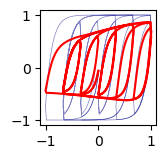

951  --  0.9053647
952  --  0.8899528
953  --  0.8747332
954  --  0.8597109
955  --  0.8449184
956  --  0.8303444
957  --  0.81599796
958  --  0.8018771
959  --  0.78795755
960  --  0.77426016
961  --  0.76071054
962  --  0.74736214
963  --  0.7342357
964  --  0.7212652
965  --  0.7085064
966  --  0.69596285
967  --  0.6836356
968  --  0.67150813
969  --  0.6595722
970  --  0.64783776
971  --  0.63630646
972  --  0.6249767
973  --  0.6138407
974  --  0.6028918
975  --  0.5921131
976  --  0.5814993
977  --  0.5710572
978  --  0.56079936
979  --  0.5507298
980  --  0.54082006
981  --  0.53105426
982  --  0.52146965
983  --  0.5120609
984  --  0.50276667
985  --  0.49360156
986  --  0.48460567
987  --  0.47579935
988  --  0.4671315
989  --  0.45861658
990  --  0.45026627
991  --  0.44207475
992  --  0.43402526
993  --  0.42604932
994  --  0.41824573
995  --  0.41060406
996  --  0.4031167
997  --  0.39578754
998  --  0.38862193
999  --  0.3815232
1000  --  0.37451157


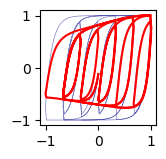

1001  --  0.36764684
1002  --  0.36088362
1003  --  0.35425338
1004  --  0.3477607
1005  --  0.34135935
1006  --  0.33510652
1007  --  0.32900083
1008  --  0.32304147
1009  --  0.31721413
1010  --  0.31151855
1011  --  0.30594558
1012  --  0.30052286
1013  --  0.29522878
1014  --  0.29006794
1015  --  0.2850024
1016  --  0.28006524
1017  --  0.27523932
1018  --  0.27052397
1019  --  0.2659191
1020  --  0.26140133
1021  --  0.2569888
1022  --  0.25265592
1023  --  0.24837743
1024  --  0.2441755
1025  --  0.24006757
1026  --  0.23605093
1027  --  0.23211502
1028  --  0.22823311
1029  --  0.22442137
1030  --  0.22069682
1031  --  0.21704933
1032  --  0.21349578
1033  --  0.21001679
1034  --  0.20660236
1035  --  0.20328112
1036  --  0.2000445
1037  --  0.19688624
1038  --  0.1938056
1039  --  0.19079652
1040  --  0.1878613
1041  --  0.18500549
1042  --  0.18220954
1043  --  0.1794877
1044  --  0.17683667
1045  --  0.17425239
1046  --  0.17173773
1047  --  0.16928041
1048  --  0.16688627
1

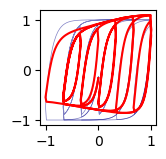

1051  --  0.16009171
1052  --  0.15794645
1053  --  0.15586011
1054  --  0.15383182
1055  --  0.15186451
1056  --  0.14991459
1057  --  0.14800578
1058  --  0.14615747
1059  --  0.14437959
1060  --  0.14266215
1061  --  0.14099246
1062  --  0.13933535
1063  --  0.13768132
1064  --  0.13601041
1065  --  0.13434364
1066  --  0.1327115
1067  --  0.13112713
1068  --  0.12959048
1069  --  0.12810016
1070  --  0.12665917
1071  --  0.12526424
1072  --  0.12391515
1073  --  0.12259443
1074  --  0.12130548
1075  --  0.120051876
1076  --  0.11883484
1077  --  0.117649674
1078  --  0.11649685
1079  --  0.11537675
1080  --  0.11428662
1081  --  0.11322217
1082  --  0.11218065
1083  --  0.11116281
1084  --  0.110171005
1085  --  0.10921114
1086  --  0.10828065
1087  --  0.107378766
1088  --  0.106503494
1089  --  0.10565506
1090  --  0.104826875
1091  --  0.104014926
1092  --  0.10321019
1093  --  0.10240908
1094  --  0.1016057
1095  --  0.10081109
1096  --  0.10002653
1097  --  0.09925041
1098  --

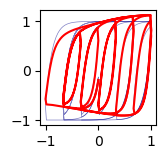

1101  --  0.09632007
1102  --  0.09563011
1103  --  0.09495441
1104  --  0.09429337
1105  --  0.09364692
1106  --  0.09301147
1107  --  0.092389956
1108  --  0.09177889
1109  --  0.09118026
1110  --  0.090591066
1111  --  0.09000695
1112  --  0.08943414
1113  --  0.0888708
1114  --  0.088316955
1115  --  0.08776388
1116  --  0.08721645
1117  --  0.086676374
1118  --  0.086142555
1119  --  0.085616805
1120  --  0.08509407
1121  --  0.08457683
1122  --  0.0840591
1123  --  0.083545424
1124  --  0.08303432
1125  --  0.082529455
1126  --  0.08203603
1127  --  0.08155664
1128  --  0.08108517
1129  --  0.08062271
1130  --  0.08016575
1131  --  0.0797179
1132  --  0.0792758
1133  --  0.078842476
1134  --  0.07841369
1135  --  0.07799125
1136  --  0.07757299
1137  --  0.07715708
1138  --  0.076747485
1139  --  0.0763399
1140  --  0.07593395
1141  --  0.07553449
1142  --  0.0751359
1143  --  0.07473942
1144  --  0.07434977
1145  --  0.073961176
1146  --  0.07357583
1147  --  0.0731991
1148  -- 

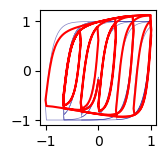

1151  --  0.07172178
1152  --  0.071362086
1153  --  0.07100767
1154  --  0.07065839
1155  --  0.07030792
1156  --  0.06995995
1157  --  0.069616005
1158  --  0.069277234
1159  --  0.06894021
1160  --  0.06860302
1161  --  0.068267114
1162  --  0.0679358
1163  --  0.06760716
1164  --  0.06727985
1165  --  0.06695486
1166  --  0.066631936
1167  --  0.06631119
1168  --  0.06599265
1169  --  0.06566987
1170  --  0.06530291
1171  --  0.06499066
1172  --  0.0646708
1173  --  0.06434943
1174  --  0.06402559
1175  --  0.063700415
1176  --  0.06336425
1177  --  0.063014075
1178  --  0.0626535
1179  --  0.062300142
1180  --  0.06198136
1181  --  0.061671656
1182  --  0.06136727
1183  --  0.06106729
1184  --  0.060772743
1185  --  0.060481686
1186  --  0.06019423
1187  --  0.059910495
1188  --  0.059630036
1189  --  0.059349257
1190  --  0.05906732
1191  --  0.058784176
1192  --  0.05849859
1193  --  0.058212113
1194  --  0.057925344
1195  --  0.05763751
1196  --  0.057352718
1197  --  0.0570702

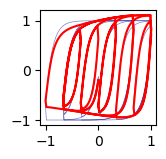

1201  --  0.055953264
1202  --  0.055679966
1203  --  0.055409126
1204  --  0.055138882
1205  --  0.05486789
1206  --  0.054597914
1207  --  0.054330476
1208  --  0.054065533
1209  --  0.053801995
1210  --  0.053538993
1211  --  0.053277418
1212  --  0.053017348
1213  --  0.052758835
1214  --  0.052501813
1215  --  0.0522454
1216  --  0.05198962
1217  --  0.051736012
1218  --  0.05148481
1219  --  0.05123584
1220  --  0.050989043
1221  --  0.05074353
1222  --  0.050499532
1223  --  0.050255723
1224  --  0.050012887
1225  --  0.04977083
1226  --  0.049529783
1227  --  0.049289662
1228  --  0.049051046
1229  --  0.048813675
1230  --  0.048578035
1231  --  0.048343897
1232  --  0.04811067
1233  --  0.047878955
1234  --  0.047648065
1235  --  0.047417887
1236  --  0.047188032
1237  --  0.046959728
1238  --  0.04673323
1239  --  0.046507813
1240  --  0.04628391
1241  --  0.04606063
1242  --  0.045838438
1243  --  0.04561662
1244  --  0.045396026
1245  --  0.0451762
1246  --  0.044957764
124

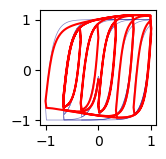

1251  --  0.04388347
1252  --  0.04367183
1253  --  0.043461706
1254  --  0.043252185
1255  --  0.043043476
1256  --  0.04283598
1257  --  0.04262949
1258  --  0.042424306
1259  --  0.042219818
1260  --  0.042016003
1261  --  0.041813657
1262  --  0.041612137
1263  --  0.041411173
1264  --  0.041212518
1265  --  0.041013256
1266  --  0.040815853
1267  --  0.040618397
1268  --  0.040421277
1269  --  0.040226784
1270  --  0.040032275
1271  --  0.039839473
1272  --  0.03964689
1273  --  0.039455127
1274  --  0.039265685
1275  --  0.03907624
1276  --  0.038887534
1277  --  0.038701028
1278  --  0.038514763
1279  --  0.03832893
1280  --  0.03814549
1281  --  0.037962086
1282  --  0.037780385
1283  --  0.037598696
1284  --  0.03741761
1285  --  0.03723885
1286  --  0.037059937
1287  --  0.036882542
1288  --  0.036705837
1289  --  0.036529638
1290  --  0.03635531
1291  --  0.036181286
1292  --  0.03600882
1293  --  0.035836432
1294  --  0.03566475
1295  --  0.035495013
1296  --  0.035325672
1

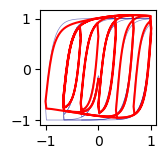

1301  --  0.034493573
1302  --  0.03433054
1303  --  0.03416803
1304  --  0.03400618
1305  --  0.03384645
1306  --  0.033686765
1307  --  0.033528425
1308  --  0.033370484
1309  --  0.033213902
1310  --  0.033057667
1311  --  0.032901898
1312  --  0.03274815
1313  --  0.032594748
1314  --  0.0324423
1315  --  0.03229061
1316  --  0.032139674
1317  --  0.03199093
1318  --  0.031842366
1319  --  0.031694718
1320  --  0.031547446
1321  --  0.03140138
1322  --  0.031255815
1323  --  0.03111076
1324  --  0.030967603
1325  --  0.030824931
1326  --  0.03068334
1327  --  0.030542443
1328  --  0.03040274
1329  --  0.030263351
1330  --  0.030124584
1331  --  0.029987618
1332  --  0.029850902
1333  --  0.02971501
1334  --  0.029579736
1335  --  0.029445656
1336  --  0.029312138
1337  --  0.029179838
1338  --  0.02904807
1339  --  0.02891701
1340  --  0.028787673
1341  --  0.028658716
1342  --  0.02853072
1343  --  0.02840348
1344  --  0.028277425
1345  --  0.028151892
1346  --  0.028027538
1347  

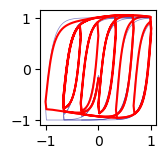

1351  --  0.027417494
1352  --  0.027297929
1353  --  0.02717883
1354  --  0.027061287
1355  --  0.02694393
1356  --  0.026827103
1357  --  0.026711117
1358  --  0.026595736
1359  --  0.026482016
1360  --  0.02636853
1361  --  0.02625541
1362  --  0.026143918
1363  --  0.026032832
1364  --  0.025922552
1365  --  0.025812596
1366  --  0.025703575
1367  --  0.025596173
1368  --  0.025488941
1369  --  0.025381997
1370  --  0.025276106
1371  --  0.025171489
1372  --  0.025067367
1373  --  0.02496358
1374  --  0.024861123
1375  --  0.02475898
1376  --  0.02465701
1377  --  0.024556069
1378  --  0.024455994
1379  --  0.024356224
1380  --  0.024256641
1381  --  0.024158087
1382  --  0.024060827
1383  --  0.023964107
1384  --  0.023867419
1385  --  0.023771882
1386  --  0.023677567
1387  --  0.023583649
1388  --  0.023490416
1389  --  0.023398533
1390  --  0.023307893
1391  --  0.023217387
1392  --  0.023126993
1393  --  0.023037715
1394  --  0.022949299
1395  --  0.022862166
1396  --  0.02277

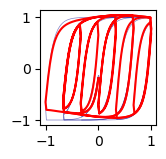

1401  --  0.022351347
1402  --  0.022268903
1403  --  0.022186328
1404  --  0.022103138
1405  --  0.02202135
1406  --  0.02193969
1407  --  0.021857643
1408  --  0.021776514
1409  --  0.021696813
1410  --  0.021617174
1411  --  0.021537356
1412  --  0.021459084
1413  --  0.021381253
1414  --  0.02130399
1415  --  0.021228477
1416  --  0.021153549
1417  --  0.021078583
1418  --  0.021005306
1419  --  0.02093238
1420  --  0.020859916
1421  --  0.020788608
1422  --  0.020717805
1423  --  0.020647189
1424  --  0.020577565
1425  --  0.02050837
1426  --  0.020439098
1427  --  0.020370765
1428  --  0.020302702
1429  --  0.020234616
1430  --  0.020167379
1431  --  0.02010038
1432  --  0.020033492
1433  --  0.019967133
1434  --  0.019900851
1435  --  0.01983577
1436  --  0.019771164
1437  --  0.019706503
1438  --  0.019643182
1439  --  0.019580984
1440  --  0.019519009
1441  --  0.019458199
1442  --  0.019399162
1443  --  0.019341566
1444  --  0.019284932
1445  --  0.01923098
1446  --  0.019178

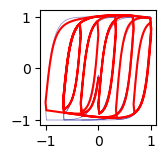

1451  --  0.018933512
1452  --  0.018885102
1453  --  0.018833417
1454  --  0.018780403
1455  --  0.01872395
1456  --  0.018663416
1457  --  0.018601077
1458  --  0.018537655
1459  --  0.018473664
1460  --  0.018409686
1461  --  0.01834688
1462  --  0.018285414
1463  --  0.01822687
1464  --  0.01817072
1465  --  0.01811744
1466  --  0.018067472
1467  --  0.018020606
1468  --  0.017975368
1469  --  0.01793176
1470  --  0.017890135
1471  --  0.017849484
1472  --  0.01780874
1473  --  0.017767083
1474  --  0.01772349
1475  --  0.017677128
1476  --  0.017628165
1477  --  0.017575484
1478  --  0.017520055
1479  --  0.017463451
1480  --  0.017406242
1481  --  0.017349124
1482  --  0.01729386
1483  --  0.017241081
1484  --  0.01719156
1485  --  0.017146736
1486  --  0.017108353
1487  --  0.017076956
1488  --  0.01705208
1489  --  0.017033786
1490  --  0.017021434
1491  --  0.017012022
1492  --  0.01700082
1493  --  0.016983623
1494  --  0.016954022
1495  --  0.01691201
1496  --  0.016857367
1

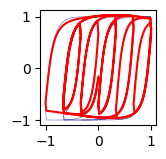

1501  --  0.016517226
1502  --  0.016458852
1503  --  0.016406083
1504  --  0.01635784
1505  --  0.016313385
1506  --  0.016271973
1507  --  0.016232634
1508  --  0.016193368
1509  --  0.016155092
1510  --  0.01611624
1511  --  0.016077641
1512  --  0.016038582
1513  --  0.015999382
1514  --  0.01596006
1515  --  0.015919156
1516  --  0.01587954
1517  --  0.01584082
1518  --  0.015802315
1519  --  0.015765602
1520  --  0.015730772
1521  --  0.015695916
1522  --  0.015663257
1523  --  0.015632713
1524  --  0.01560333
1525  --  0.015574493
1526  --  0.015547575
1527  --  0.015520143
1528  --  0.015492019
1529  --  0.015463387
1530  --  0.015434478
1531  --  0.015403779
1532  --  0.01537014
1533  --  0.015335108
1534  --  0.015298501
1535  --  0.01526061
1536  --  0.015220382
1537  --  0.015180108
1538  --  0.015139777
1539  --  0.0150984945
1540  --  0.015058277
1541  --  0.015019037
1542  --  0.01498085
1543  --  0.014943617
1544  --  0.014907629
1545  --  0.014873022
1546  --  0.014838

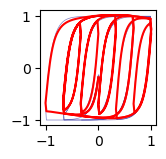

1551  --  0.014673986
1552  --  0.014642553
1553  --  0.014610733
1554  --  0.014579955
1555  --  0.01454921
1556  --  0.014519859
1557  --  0.014490424
1558  --  0.014462306
1559  --  0.014435765
1560  --  0.014410339
1561  --  0.01438497
1562  --  0.014361035
1563  --  0.014338986
1564  --  0.0143166445
1565  --  0.014293642
1566  --  0.014271304
1567  --  0.01424802
1568  --  0.014224165
1569  --  0.0141986795
1570  --  0.014170325
1571  --  0.014140664
1572  --  0.014108594
1573  --  0.014075011
1574  --  0.01403983
1575  --  0.014003483
1576  --  0.013967006
1577  --  0.013930848
1578  --  0.013895157
1579  --  0.0138598755
1580  --  0.013825716
1581  --  0.013792422
1582  --  0.013760963
1583  --  0.013729683
1584  --  0.013699446
1585  --  0.013669981
1586  --  0.013641272
1587  --  0.013612769
1588  --  0.013584831
1589  --  0.0135575365
1590  --  0.013529637
1591  --  0.0135023175
1592  --  0.013475843
1593  --  0.01345007
1594  --  0.013424214
1595  --  0.0134001225
1596  -- 

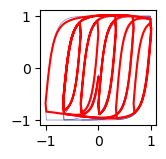

1601  --  0.013278769
1602  --  0.013261389
1603  --  0.013243382
1604  --  0.0132255815
1605  --  0.01320593
1606  --  0.013184809
1607  --  0.013160706
1608  --  0.013134447
1609  --  0.013106433
1610  --  0.0130761275
1611  --  0.01304274
1612  --  0.013008782
1613  --  0.012974839
1614  --  0.012939959
1615  --  0.012905903
1616  --  0.012872878
1617  --  0.012841152
1618  --  0.01281083
1619  --  0.012781704
1620  --  0.012753759
1621  --  0.012726821
1622  --  0.0127011025
1623  --  0.012674737
1624  --  0.012648892
1625  --  0.012623537
1626  --  0.012598624
1627  --  0.01257391
1628  --  0.012549578
1629  --  0.0125257075
1630  --  0.012501291
1631  --  0.012477954
1632  --  0.012454238
1633  --  0.012431717
1634  --  0.012410143
1635  --  0.012388668
1636  --  0.012368918
1637  --  0.012350515
1638  --  0.012333992
1639  --  0.012319548
1640  --  0.012304794
1641  --  0.012292434
1642  --  0.0122815035
1643  --  0.012272386
1644  --  0.012263891
1645  --  0.012253121
1646  -- 

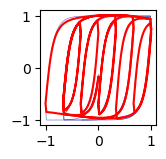

1651  --  0.012121028
1652  --  0.01208734
1653  --  0.012052562
1654  --  0.012017846
1655  --  0.0119842505
1656  --  0.011952365
1657  --  0.011922381
1658  --  0.01189427
1659  --  0.011868165
1660  --  0.011844196
1661  --  0.011820684
1662  --  0.011798773
1663  --  0.011777558
1664  --  0.011756751
1665  --  0.011736151
1666  --  0.011715671
1667  --  0.011695303
1668  --  0.011675261
1669  --  0.011655776
1670  --  0.011636027
1671  --  0.011617407
1672  --  0.011600298
1673  --  0.011584932
1674  --  0.011573109
1675  --  0.011563966
1676  --  0.011557114
1677  --  0.011553442
1678  --  0.011552886
1679  --  0.0115537755
1680  --  0.011553475
1681  --  0.011551819
1682  --  0.011547142
1683  --  0.011536726
1684  --  0.011517888
1685  --  0.011492803
1686  --  0.011461104
1687  --  0.011423919
1688  --  0.011385474
1689  --  0.0113474205
1690  --  0.011311204
1691  --  0.011277927
1692  --  0.011247883
1693  --  0.01122086
1694  --  0.011196629
1695  --  0.011174778
1696  --  

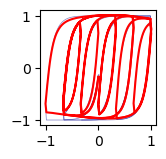

1701  --  0.011065358
1702  --  0.011047496
1703  --  0.011029607
1704  --  0.011011877
1705  --  0.010995309
1706  --  0.010978836
1707  --  0.010963244
1708  --  0.010949611
1709  --  0.010937684
1710  --  0.01092828
1711  --  0.0109213395
1712  --  0.01091516
1713  --  0.01091088
1714  --  0.010908279
1715  --  0.010906394
1716  --  0.0109023955
1717  --  0.010896509
1718  --  0.010887464
1719  --  0.010873506
1720  --  0.010854862
1721  --  0.010830277
1722  --  0.010803113
1723  --  0.010773751
1724  --  0.010743838
1725  --  0.010714451
1726  --  0.010686484
1727  --  0.010660426
1728  --  0.010636025
1729  --  0.01061392
1730  --  0.010594064
1731  --  0.010575078
1732  --  0.010557625
1733  --  0.0105413
1734  --  0.010525521
1735  --  0.010509868
1736  --  0.010494446
1737  --  0.01047917
1738  --  0.010462909
1739  --  0.010446818
1740  --  0.010431073
1741  --  0.010415901
1742  --  0.01040181
1743  --  0.010387823
1744  --  0.010375859
1745  --  0.0103665525
1746  --  0.010

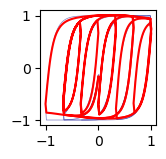

1751  --  0.010346462
1752  --  0.010345748
1753  --  0.010343175
1754  --  0.010334503
1755  --  0.010321973
1756  --  0.010304682
1757  --  0.010282663
1758  --  0.010256465
1759  --  0.010227737
1760  --  0.01019797
1761  --  0.010168944
1762  --  0.010141619
1763  --  0.010116124
1764  --  0.0100932885
1765  --  0.010073406
1766  --  0.010054838
1767  --  0.010038226
1768  --  0.010023252
1769  --  0.010009441
1770  --  0.009996316
1771  --  0.009982551
1772  --  0.009968918
1773  --  0.00995496
1774  --  0.009940529
1775  --  0.009925667
1776  --  0.009910561
1777  --  0.009896207
1778  --  0.0098803425
1779  --  0.009865913
1780  --  0.009852896
1781  --  0.009840401
1782  --  0.009829868
1783  --  0.009822024
1784  --  0.009816762
1785  --  0.00981258
1786  --  0.009811626
1787  --  0.009811996
1788  --  0.009812228
1789  --  0.009813543
1790  --  0.009814605
1791  --  0.009811741
1792  --  0.009805116
1793  --  0.00979343
1794  --  0.009776951
1795  --  0.00975532
1796  --  0.0

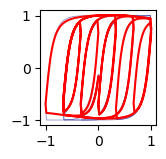

1801  --  0.009589431
1802  --  0.009568553
1803  --  0.009550372
1804  --  0.009535074
1805  --  0.009521966
1806  --  0.009510603
1807  --  0.009500059
1808  --  0.009489819
1809  --  0.00947936
1810  --  0.009468209
1811  --  0.009456288
1812  --  0.00944279
1813  --  0.009427694
1814  --  0.009412145
1815  --  0.009396509
1816  --  0.00938027
1817  --  0.009365097
1818  --  0.009351584
1819  --  0.009339235
1820  --  0.009329889
1821  --  0.009324192
1822  --  0.009320827
1823  --  0.009321903
1824  --  0.009325459
1825  --  0.009331304
1826  --  0.009339411
1827  --  0.009347595
1828  --  0.009352174
1829  --  0.009352062
1830  --  0.0093453545
1831  --  0.009331666
1832  --  0.009309713
1833  --  0.009280679
1834  --  0.009247575
1835  --  0.009212689
1836  --  0.009179503
1837  --  0.009149577
1838  --  0.009123952
1839  --  0.009102881
1840  --  0.009086126
1841  --  0.009072444
1842  --  0.0090613635
1843  --  0.009052081
1844  --  0.009043976
1845  --  0.009036047
1846  --  0

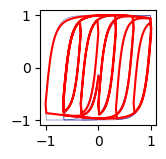

1851  --  0.008962829
1852  --  0.008946319
1853  --  0.008928928
1854  --  0.0089125605
1855  --  0.008897816
1856  --  0.008885623
1857  --  0.008876192
1858  --  0.008871341
1859  --  0.008870422
1860  --  0.008873587
1861  --  0.008881585
1862  --  0.008891646
1863  --  0.008903517
1864  --  0.008914788
1865  --  0.008922038
1866  --  0.008921727
1867  --  0.008913145
1868  --  0.008895311
1869  --  0.008869778
1870  --  0.008837996
1871  --  0.008803479
1872  --  0.00876897
1873  --  0.008737046
1874  --  0.008708738
1875  --  0.008684672
1876  --  0.008665484
1877  --  0.008650901
1878  --  0.008640016
1879  --  0.008631533
1880  --  0.008624867
1881  --  0.008618959
1882  --  0.008613002
1883  --  0.008606207
1884  --  0.008598406
1885  --  0.008587839
1886  --  0.008575496
1887  --  0.0085611725
1888  --  0.008545359
1889  --  0.008528713
1890  --  0.008512176
1891  --  0.008495927
1892  --  0.008481903
1893  --  0.008470086
1894  --  0.008462493
1895  --  0.008458105
1896  -- 

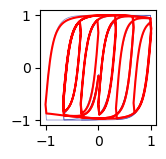

1901  --  0.008500526
1902  --  0.00850342
1903  --  0.008499719
1904  --  0.008487656
1905  --  0.008468097
1906  --  0.0084427
1907  --  0.0084136715
1908  --  0.008383191
1909  --  0.008353323
1910  --  0.008325659
1911  --  0.008302045
1912  --  0.008282684
1913  --  0.008266639
1914  --  0.008253814
1915  --  0.008243468
1916  --  0.008235
1917  --  0.008227585
1918  --  0.008220669
1919  --  0.008213622
1920  --  0.00820572
1921  --  0.0081967
1922  --  0.008186084
1923  --  0.008174474
1924  --  0.008160936
1925  --  0.008147283
1926  --  0.0081330985
1927  --  0.008119918
1928  --  0.008108185
1929  --  0.008097846
1930  --  0.008090615
1931  --  0.008086693
1932  --  0.008084743
1933  --  0.008086709
1934  --  0.008092267
1935  --  0.0080988575
1936  --  0.008107421
1937  --  0.008114997
1938  --  0.008117269
1939  --  0.008115328
1940  --  0.008107581
1941  --  0.008093846
1942  --  0.008074391
1943  --  0.008050308
1944  --  0.008023875
1945  --  0.00799636
1946  --  0.00796

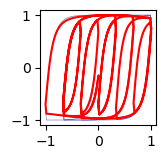

1951  --  0.007887229
1952  --  0.007880227
1953  --  0.007874665
1954  --  0.007869928
1955  --  0.007865444
1956  --  0.007860339
1957  --  0.007854042
1958  --  0.007846195
1959  --  0.007836767
1960  --  0.007824909
1961  --  0.007811579
1962  --  0.0077972286
1963  --  0.007783093
1964  --  0.007768036
1965  --  0.007754867
1966  --  0.007744431
1967  --  0.0077364454
1968  --  0.0077328985
1969  --  0.007734891
1970  --  0.007739976
1971  --  0.007750905
1972  --  0.007766647
1973  --  0.0077830167
1974  --  0.0077994457
1975  --  0.007812094
1976  --  0.007816622
1977  --  0.0078120204
1978  --  0.0077966135
1979  --  0.0077713863
1980  --  0.007739128
1981  --  0.007703113
1982  --  0.0076676533
1983  --  0.007635645
1984  --  0.007608689
1985  --  0.0075878957
1986  --  0.0075731454
1987  --  0.0075634792
1988  --  0.007558642
1989  --  0.0075570466
1990  --  0.0075575975
1991  --  0.007557513
1992  --  0.0075567476
1993  --  0.007553954
1994  --  0.007548424
1995  --  0.00753

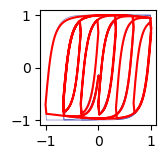

2001  --  0.007443762
2002  --  0.007430373
2003  --  0.0074207364
2004  --  0.007416562
2005  --  0.0074173957
2006  --  0.007424165
2007  --  0.007435121
2008  --  0.007450182
2009  --  0.007466087
2010  --  0.0074800774
2011  --  0.0074890805
2012  --  0.0074906005
2013  --  0.0074823177
2014  --  0.0074638943
2015  --  0.0074380063
2016  --  0.0074073486
2017  --  0.007375147
2018  --  0.0073438054
2019  --  0.0073166084
2020  --  0.007294992
2021  --  0.0072791274
2022  --  0.0072682165
2023  --  0.0072614113
2024  --  0.007257915
2025  --  0.0072565163
2026  --  0.0072555817
2027  --  0.0072539025
2028  --  0.007250674
2029  --  0.007245173
2030  --  0.0072369627
2031  --  0.007226191
2032  --  0.0072132703
2033  --  0.007198903
2034  --  0.007183922
2035  --  0.007169706
2036  --  0.007156184
2037  --  0.0071454803
2038  --  0.00713777
2039  --  0.0071335435
2040  --  0.007133793
2041  --  0.0071381917
2042  --  0.0071452656
2043  --  0.0071555222
2044  --  0.007165863
2045  -- 

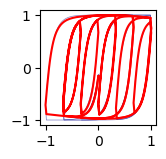

2051  --  0.0071170484
2052  --  0.007091141
2053  --  0.007065877
2054  --  0.0070431656
2055  --  0.007023992
2056  --  0.0070088226
2057  --  0.006997643
2058  --  0.006989994
2059  --  0.006985244
2060  --  0.006982866
2061  --  0.0069814106
2062  --  0.006980057
2063  --  0.0069779707
2064  --  0.006974326
2065  --  0.0069685755
2066  --  0.0069605843
2067  --  0.006950264
2068  --  0.0069379
2069  --  0.006924395
2070  --  0.00690971
2071  --  0.006895798
2072  --  0.0068835975
2073  --  0.006874316
2074  --  0.006868169
2075  --  0.006866605
2076  --  0.0068692523
2077  --  0.006877368
2078  --  0.00688895
2079  --  0.0069035203
2080  --  0.006919387
2081  --  0.006931893
2082  --  0.0069398475
2083  --  0.006941218
2084  --  0.0069327606
2085  --  0.0069151004
2086  --  0.006890269
2087  --  0.0068606664
2088  --  0.0068300916
2089  --  0.0068017235
2090  --  0.006777458
2091  --  0.006758531
2092  --  0.0067454316
2093  --  0.006737706
2094  --  0.006734711
2095  --  0.0067353

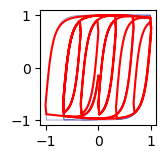

2101  --  0.006736823
2102  --  0.0067260168
2103  --  0.0067119645
2104  --  0.006695235
2105  --  0.0066771936
2106  --  0.0066592437
2107  --  0.0066429703
2108  --  0.00663038
2109  --  0.006623279
2110  --  0.0066209715
2111  --  0.0066251205
2112  --  0.006635476
2113  --  0.0066514257
2114  --  0.00667075
2115  --  0.006691106
2116  --  0.006707608
2117  --  0.0067176195
2118  --  0.006717129
2119  --  0.0067058643
2120  --  0.0066844528
2121  --  0.006654861
2122  --  0.006622101
2123  --  0.006589548
2124  --  0.006560994
2125  --  0.0065379688
2126  --  0.006521524
2127  --  0.006511411
2128  --  0.006506873
2129  --  0.006506593
2130  --  0.0065088156
2131  --  0.0065117097
2132  --  0.0065141115
2133  --  0.006514214
2134  --  0.0065111676
2135  --  0.006504483
2136  --  0.006494187
2137  --  0.0064812624
2138  --  0.006465672
2139  --  0.006449505
2140  --  0.0064339945
2141  --  0.0064206747
2142  --  0.0064105717
2143  --  0.006404896
2144  --  0.006404492
2145  --  0.00

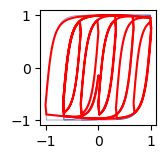

2151  --  0.006467921
2152  --  0.00646452
2153  --  0.0064527094
2154  --  0.0064343405
2155  --  0.0064114574
2156  --  0.006386603
2157  --  0.006361919
2158  --  0.0063396865
2159  --  0.0063213073
2160  --  0.006307683
2161  --  0.006299055
2162  --  0.0062939906
2163  --  0.006292245
2164  --  0.006292446
2165  --  0.0062929085
2166  --  0.0062926873
2167  --  0.0062910756
2168  --  0.006287304
2169  --  0.0062810015
2170  --  0.006271934
2171  --  0.006260831
2172  --  0.0062482134
2173  --  0.0062350607
2174  --  0.006222713
2175  --  0.006212454
2176  --  0.00620553
2177  --  0.0062014204
2178  --  0.0062014274
2179  --  0.0062059523
2180  --  0.0062146196
2181  --  0.006227108
2182  --  0.0062402515
2183  --  0.0062535624
2184  --  0.006264525
2185  --  0.006269789
2186  --  0.0062668403
2187  --  0.0062563834
2188  --  0.006238658
2189  --  0.006215057
2190  --  0.0061895745
2191  --  0.006164531
2192  --  0.0061419164
2193  --  0.0061231786
2194  --  0.006109355
2195  --  0

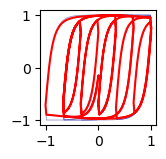

2201  --  0.0061015785
2202  --  0.0060993982
2203  --  0.0060941507
2204  --  0.0060858205
2205  --  0.0060747196
2206  --  0.006061515
2207  --  0.006047288
2208  --  0.0060337423
2209  --  0.0060214195
2210  --  0.0060126637
2211  --  0.006007945
2212  --  0.0060081533
2213  --  0.006014674
2214  --  0.0060263993
2215  --  0.0060421643
2216  --  0.006060545
2217  --  0.006078932
2218  --  0.006093069
2219  --  0.00610067
2220  --  0.006099347
2221  --  0.0060878545
2222  --  0.006067552
2223  --  0.00604054
2224  --  0.0060106805
2225  --  0.0059815543
2226  --  0.005956185
2227  --  0.005936214
2228  --  0.0059227697
2229  --  0.0059155887
2230  --  0.0059139715
2231  --  0.005916419
2232  --  0.0059210085
2233  --  0.005926036
2234  --  0.0059297024
2235  --  0.0059303935
2236  --  0.005927002
2237  --  0.0059195478
2238  --  0.0059081404
2239  --  0.005893708
2240  --  0.005877821
2241  --  0.005861929
2242  --  0.005847814
2243  --  0.0058375075
2244  --  0.0058318414
2245  --  

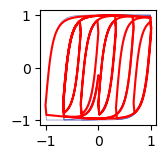

2251  --  0.0059157806
2252  --  0.0059225624
2253  --  0.0059202733
2254  --  0.005907637
2255  --  0.005887542
2256  --  0.005862001
2257  --  0.0058343476
2258  --  0.0058075245
2259  --  0.0057839626
2260  --  0.0057653165
2261  --  0.005752216
2262  --  0.005744538
2263  --  0.0057413047
2264  --  0.0057412903
2265  --  0.0057427264
2266  --  0.005744076
2267  --  0.0057441886
2268  --  0.0057423343
2269  --  0.005738047
2270  --  0.005730795
2271  --  0.0057211686
2272  --  0.0057091843
2273  --  0.0056970078
2274  --  0.0056856633
2275  --  0.005676477
2276  --  0.005671075
2277  --  0.0056701787
2278  --  0.005673363
2279  --  0.005681501
2280  --  0.005694612
2281  --  0.0057105194
2282  --  0.005727423
2283  --  0.0057424554
2284  --  0.0057522743
2285  --  0.0057553956
2286  --  0.0057498426
2287  --  0.005735334
2288  --  0.005714185
2289  --  0.0056889215
2290  --  0.00566252
2291  --  0.0056377593
2292  --  0.005616324
2293  --  0.005599172
2294  --  0.0055875536
2295  --

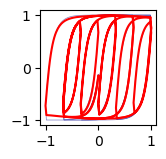

2301  --  0.00557189
2302  --  0.0055663786
2303  --  0.0055588796
2304  --  0.005549603
2305  --  0.0055393046
2306  --  0.005529215
2307  --  0.005520656
2308  --  0.005514253
2309  --  0.0055105793
2310  --  0.005510485
2311  --  0.00551376
2312  --  0.0055213035
2313  --  0.005531718
2314  --  0.0055441377
2315  --  0.005557022
2316  --  0.005567598
2317  --  0.0055734813
2318  --  0.005573482
2319  --  0.005566676
2320  --  0.005553458
2321  --  0.00553514
2322  --  0.005514041
2323  --  0.0054924428
2324  --  0.005471763
2325  --  0.0054538874
2326  --  0.0054398007
2327  --  0.0054298486
2328  --  0.005424314
2329  --  0.0054223053
2330  --  0.0054225363
2331  --  0.0054237656
2332  --  0.0054249302
2333  --  0.005424896
2334  --  0.00542285
2335  --  0.005418344
2336  --  0.005411393
2337  --  0.0054024337
2338  --  0.0053923363
2339  --  0.0053814244
2340  --  0.0053715208
2341  --  0.0053635454
2342  --  0.0053588976
2343  --  0.0053583067
2344  --  0.005361974
2345  --  0.00

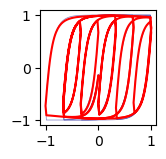

2351  --  0.005443716
2352  --  0.005438733
2353  --  0.005425412
2354  --  0.0054051345
2355  --  0.005380372
2356  --  0.0053548105
2357  --  0.0053308154
2358  --  0.005310343
2359  --  0.0052948906
2360  --  0.0052851965
2361  --  0.0052805273
2362  --  0.0052801683
2363  --  0.0052828323
2364  --  0.00528656
2365  --  0.0052896305
2366  --  0.0052908617
2367  --  0.0052892994
2368  --  0.005284436
2369  --  0.0052762865
2370  --  0.0052657146
2371  --  0.005253163
2372  --  0.0052405726
2373  --  0.0052293283
2374  --  0.0052210256
2375  --  0.005217466
2376  --  0.0052190446
2377  --  0.005226633
2378  --  0.0052397917
2379  --  0.0052577183
2380  --  0.00527766
2381  --  0.005296984
2382  --  0.005313088
2383  --  0.005321832
2384  --  0.0053203083
2385  --  0.0053082504
2386  --  0.0052866656
2387  --  0.005259448
2388  --  0.0052300007
2389  --  0.005202185
2390  --  0.005178681
2391  --  0.005161418
2392  --  0.0051510693
2393  --  0.0051468275
2394  --  0.005147172
2395  -- 

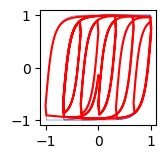

2401  --  0.0051438627
2402  --  0.0051320908
2403  --  0.0051192204
2404  --  0.005106813
2405  --  0.0050960933
2406  --  0.0050891573
2407  --  0.0050876923
2408  --  0.0050925487
2409  --  0.005102442
2410  --  0.0051172306
2411  --  0.005134832
2412  --  0.0051532183
2413  --  0.0051693697
2414  --  0.005179153
2415  --  0.005181089
2416  --  0.0051729656
2417  --  0.005156225
2418  --  0.0051330207
2419  --  0.0051069083
2420  --  0.0050810096
2421  --  0.005058511
2422  --  0.0050409823
2423  --  0.0050290423
2424  --  0.0050226417
2425  --  0.0050208163
2426  --  0.00502208
2427  --  0.0050247516
2428  --  0.0050273826
2429  --  0.0050283642
2430  --  0.005026795
2431  --  0.005022255
2432  --  0.0050148885
2433  --  0.005005393
2434  --  0.004994943
2435  --  0.0049842005
2436  --  0.004975049
2437  --  0.004968977
2438  --  0.0049671894
2439  --  0.0049700234
2440  --  0.0049770093
2441  --  0.004988223
2442  --  0.005002297
2443  --  0.005017133
2444  --  0.0050304467
2445  

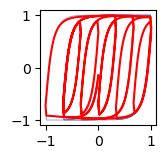

2451  --  0.004965631
2452  --  0.0049456
2453  --  0.0049290233
2454  --  0.004916572
2455  --  0.0049085235
2456  --  0.004905085
2457  --  0.0049048583
2458  --  0.004906343
2459  --  0.004908196
2460  --  0.004908978
2461  --  0.004907912
2462  --  0.0049044145
2463  --  0.0048984066
2464  --  0.0048903506
2465  --  0.0048810164
2466  --  0.004871077
2467  --  0.0048623816
2468  --  0.0048564216
2469  --  0.004854514
2470  --  0.00485645
2471  --  0.0048634554
2472  --  0.0048750574
2473  --  0.004890197
2474  --  0.004907601
2475  --  0.004923931
2476  --  0.0049358117
2477  --  0.0049416036
2478  --  0.00493927
2479  --  0.0049283914
2480  --  0.004910123
2481  --  0.004887236
2482  --  0.00486284
2483  --  0.004839658
2484  --  0.004819954
2485  --  0.0048051393
2486  --  0.0047963522
2487  --  0.004793013
2488  --  0.0047933846
2489  --  0.004796318
2490  --  0.004800115
2491  --  0.0048029157
2492  --  0.0048036072
2493  --  0.0048013283
2494  --  0.0047958484
2495  --  0.0047

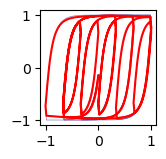

2501  --  0.0047450936
2502  --  0.004752431
2503  --  0.004765817
2504  --  0.004783988
2505  --  0.004804136
2506  --  0.0048233727
2507  --  0.004837739
2508  --  0.0048443396
2509  --  0.0048411316
2510  --  0.00482826
2511  --  0.004807138
2512  --  0.004781042
2513  --  0.0047539836
2514  --  0.004729523
2515  --  0.004710057
2516  --  0.004696703
2517  --  0.004689962
2518  --  0.004688916
2519  --  0.0046919202
2520  --  0.0046970355
2521  --  0.0047021154
2522  --  0.0047052214
2523  --  0.0047051962
2524  --  0.00470161
2525  --  0.0046944586
2526  --  0.0046843654
2527  --  0.004672302
2528  --  0.0046601854
2529  --  0.0046499716
2530  --  0.0046437983
2531  --  0.004642822
2532  --  0.00464851
2533  --  0.0046610036
2534  --  0.004678926
2535  --  0.0047000973
2536  --  0.004721077
2537  --  0.004737977
2538  --  0.004747307
2539  --  0.0047463463
2540  --  0.0047340114
2541  --  0.0047130715
2542  --  0.004686795
2543  --  0.004659413
2544  --  0.0046344395
2545  --  0.00

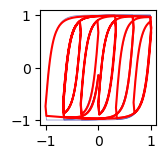

2551  --  0.004606963
2552  --  0.0046102526
2553  --  0.0046101925
2554  --  0.004606306
2555  --  0.0045987647
2556  --  0.0045883534
2557  --  0.004576428
2558  --  0.004564799
2559  --  0.0045550806
2560  --  0.004549668
2561  --  0.0045503723
2562  --  0.004556931
2563  --  0.0045697596
2564  --  0.0045876307
2565  --  0.0046071545
2566  --  0.004625283
2567  --  0.004638154
2568  --  0.0046433513
2569  --  0.004638713
2570  --  0.004624933
2571  --  0.0046038334
2572  --  0.0045789573
2573  --  0.0045541804
2574  --  0.004532528
2575  --  0.004515891
2576  --  0.0045058574
2577  --  0.004501832
2578  --  0.0045027477
2579  --  0.0045068087
2580  --  0.0045121526
2581  --  0.004516671
2582  --  0.004518553
2583  --  0.0045170323
2584  --  0.004511923
2585  --  0.0045037195
2586  --  0.004493391
2587  --  0.0044823773
2588  --  0.0044723693
2589  --  0.004465243
2590  --  0.004462737
2591  --  0.004466544
2592  --  0.0044758734
2593  --  0.00449058
2594  --  0.004508506
2595  --  0

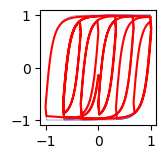

2601  --  0.0045014583
2602  --  0.0044772746
2603  --  0.004454716
2604  --  0.0044367164
2605  --  0.0044247205
2606  --  0.004418837
2607  --  0.0044183657
2608  --  0.004421796
2609  --  0.0044272803
2610  --  0.004432688
2611  --  0.0044359765
2612  --  0.0044359225
2613  --  0.0044321124
2614  --  0.0044248425
2615  --  0.0044150124
2616  --  0.004403959
2617  --  0.0043932963
2618  --  0.0043850015
2619  --  0.0043810215
2620  --  0.004382486
2621  --  0.004389714
2622  --  0.0044023558
2623  --  0.0044193505
2624  --  0.0044378773
2625  --  0.004454249
2626  --  0.004465197
2627  --  0.0044677765
2628  --  0.0044611283
2629  --  0.004445731
2630  --  0.004423913
2631  --  0.0043998067
2632  --  0.004376745
2633  --  0.0043577026
2634  --  0.004344459
2635  --  0.0043379064
2636  --  0.0043373364
2637  --  0.0043411246
2638  --  0.0043472387
2639  --  0.0043534203
2640  --  0.004357657
2641  --  0.004358528
2642  --  0.0043554557
2643  --  0.0043484806
2644  --  0.0043384084
264

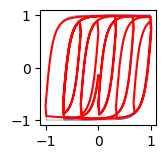

2651  --  0.004322409
2652  --  0.004339829
2653  --  0.004358658
2654  --  0.0043750126
2655  --  0.0043857223
2656  --  0.0043877494
2657  --  0.0043800427
2658  --  0.004363977
2659  --  0.0043419907
2660  --  0.0043178685
2661  --  0.004295381
2662  --  0.004277127
2663  --  0.004265071
2664  --  0.0042600003
2665  --  0.0042612227
2666  --  0.004266669
2667  --  0.00427417
2668  --  0.004281228
2669  --  0.004285908
2670  --  0.0042867474
2671  --  0.0042832065
2672  --  0.0042754062
2673  --  0.004264358
2674  --  0.0042517562
2675  --  0.0042396006
2676  --  0.004230176
2677  --  0.004225742
2678  --  0.004227895
2679  --  0.004236971
2680  --  0.0042513683
2681  --  0.0042695734
2682  --  0.0042880825
2683  --  0.0043028467
2684  --  0.004310685
2685  --  0.0043092323
2686  --  0.0042984583
2687  --  0.0042798403
2688  --  0.004256677
2689  --  0.0042327046
2690  --  0.0042117294
2691  --  0.004196022
2692  --  0.004187421
2693  --  0.0041855243
2694  --  0.004189012
2695  --  

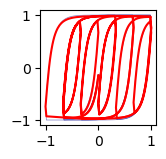

2701  --  0.0041981386
2702  --  0.0041861436
2703  --  0.004173536
2704  --  0.0041623656
2705  --  0.0041548233
2706  --  0.004153004
2707  --  0.0041582333
2708  --  0.004169672
2709  --  0.0041861157
2710  --  0.004204718
2711  --  0.0042220224
2712  --  0.0042340904
2713  --  0.0042376723
2714  --  0.004231049
2715  --  0.0042155916
2716  --  0.0041936385
2717  --  0.0041691493
2718  --  0.0041456483
2719  --  0.0041272175
2720  --  0.0041162074
2721  --  0.004112781
2722  --  0.004115917
2723  --  0.004123878
2724  --  0.004134174
2725  --  0.0041437754
2726  --  0.0041500656
2727  --  0.0041516037
2728  --  0.0041479105
2729  --  0.0041393247
2730  --  0.0041270964
2731  --  0.0041131615
2732  --  0.0040997467
2733  --  0.0040891096
2734  --  0.0040833782
2735  --  0.0040844316
2736  --  0.0040919436
2737  --  0.0041050343
2738  --  0.0041217776
2739  --  0.0041387635
2740  --  0.0041523916
2741  --  0.00415915
2742  --  0.0041567003
2743  --  0.0041449666
2744  --  0.0041264542

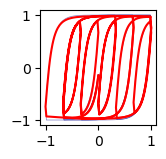

2751  --  0.0040533682
2752  --  0.0040627094
2753  --  0.0040724543
2754  --  0.0040801023
2755  --  0.0040837643
2756  --  0.0040825815
2757  --  0.004076528
2758  --  0.0040664156
2759  --  0.004053859
2760  --  0.004040872
2761  --  0.0040295776
2762  --  0.0040219906
2763  --  0.0040198127
2764  --  0.0040239734
2765  --  0.0040340307
2766  --  0.0040485193
2767  --  0.004064822
2768  --  0.0040794215
2769  --  0.004088656
2770  --  0.0040899594
2771  --  0.0040825354
2772  --  0.004067565
2773  --  0.0040477533
2774  --  0.004026574
2775  --  0.0040073344
2776  --  0.003992807
2777  --  0.0039849877
2778  --  0.0039845495
2779  --  0.00399036
2780  --  0.004000557
2781  --  0.004012564
2782  --  0.004023737
2783  --  0.0040315283
2784  --  0.0040343627
2785  --  0.0040314295
2786  --  0.00402289
2787  --  0.0040100273
2788  --  0.003994841
2789  --  0.0039798734
2790  --  0.0039677205
2791  --  0.0039605396
2792  --  0.00396004
2793  --  0.003966235
2794  --  0.003978603
2795  --

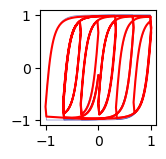

2801  --  0.0039984724
2802  --  0.003976304
2803  --  0.003954778
2804  --  0.0039370847
2805  --  0.003926165
2806  --  0.00392338
2807  --  0.0039286013
2808  --  0.003940061
2809  --  0.003955155
2810  --  0.003970694
2811  --  0.003983638
2812  --  0.003991384
2813  --  0.0039923936
2814  --  0.0039862413
2815  --  0.003973845
2816  --  0.003957095
2817  --  0.0039385394
2818  --  0.003921174
2819  --  0.003907922
2820  --  0.0039011915
2821  --  0.0039019124
2822  --  0.0039099907
2823  --  0.0039240425
2824  --  0.0039408584
2825  --  0.003956639
2826  --  0.0039670407
2827  --  0.003969146
2828  --  0.003961922
2829  --  0.0039463774
2830  --  0.0039255545
2831  --  0.0039032304
2832  --  0.0038837737
2833  --  0.0038703105
2834  --  0.0038649447
2835  --  0.0038679566
2836  --  0.0038783124
2837  --  0.0038938178
2838  --  0.0039113746
2839  --  0.0039275065
2840  --  0.0039393
2841  --  0.0039444542
2842  --  0.0039420812
2843  --  0.003932505
2844  --  0.0039172284
2845  -- 

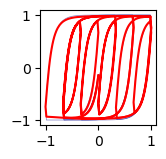

2851  --  0.003858886
2852  --  0.0038733247
2853  --  0.0038891302
2854  --  0.0039019266
2855  --  0.003908127
2856  --  0.003905956
2857  --  0.0038951414
2858  --  0.0038773709
2859  --  0.003856417
2860  --  0.0038364553
2861  --  0.0038210019
2862  --  0.0038125515
2863  --  0.003812589
2864  --  0.0038208137
2865  --  0.003835678
2866  --  0.003854516
2867  --  0.0038738619
2868  --  0.0038904464
2869  --  0.003901348
2870  --  0.003904537
2871  --  0.0038994204
2872  --  0.0038866259
2873  --  0.0038680742
2874  --  0.0038466784
2875  --  0.0038255926
2876  --  0.0038081035
2877  --  0.0037969712
2878  --  0.003794094
2879  --  0.003799538
2880  --  0.0038120209
2881  --  0.003828434
2882  --  0.0038447566
2883  --  0.003856655
2884  --  0.0038605682
2885  --  0.0038551497
2886  --  0.0038409957
2887  --  0.0038207022
2888  --  0.00379811
2889  --  0.003778081
2890  --  0.0037643418
2891  --  0.0037592866
2892  --  0.003763648
2893  --  0.0037765752
2894  --  0.0037959171
2895 

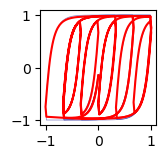

2901  --  0.0038419254
2902  --  0.0038200507
2903  --  0.0037962398
2904  --  0.0037739691
2905  --  0.0037566072
2906  --  0.003746766
2907  --  0.0037457969
2908  --  0.0037534772
2909  --  0.0037678876
2910  --  0.0037852873
2911  --  0.003801232
2912  --  0.00381168
2913  --  0.003813251
2914  --  0.0038047961
2915  --  0.0037876929
2916  --  0.0037654403
2917  --  0.0037423796
2918  --  0.0037230751
2919  --  0.0037114928
2920  --  0.0037098136
2921  --  0.003718161
2922  --  0.0037350468
2923  --  0.0037577657
2924  --  0.0037822742
2925  --  0.0038045521
2926  --  0.0038209178
2927  --  0.0038285044
2928  --  0.0038260112
2929  --  0.003813772
2930  --  0.0037936103
2931  --  0.0037690476
2932  --  0.0037439694
2933  --  0.0037221182
2934  --  0.0037067255
2935  --  0.0036998093
2936  --  0.0037019022
2937  --  0.0037117722
2938  --  0.0037263634
2939  --  0.0037417822
2940  --  0.0037536859
2941  --  0.0037585564
2942  --  0.0037542544
2943  --  0.0037412974
2944  --  0.003721

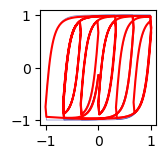

2951  --  0.0036970659
2952  --  0.0037192905
2953  --  0.003741138
2954  --  0.0037587553
2955  --  0.0037693009
2956  --  0.003771207
2957  --  0.0037642918
2958  --  0.0037497126
2959  --  0.0037299015
2960  --  0.0037078413
2961  --  0.0036868432
2962  --  0.003670018
2963  --  0.003659558
2964  --  0.0036567075
2965  --  0.0036612255
2966  --  0.0036714133
2967  --  0.0036842506
2968  --  0.0036959988
2969  --  0.003703318
2970  --  0.0037035744
2971  --  0.003695858
2972  --  0.0036813547
2973  --  0.0036630516
2974  --  0.0036443644
2975  --  0.0036291215
2976  --  0.0036201724
2977  --  0.0036192583
2978  --  0.0036269103
2979  --  0.0036420526
2980  --  0.003662459
2981  --  0.0036849796
2982  --  0.0037058638
2983  --  0.003721897
2984  --  0.0037305912
2985  --  0.0037306992
2986  --  0.0037220584
2987  --  0.0037061016
2988  --  0.0036852688
2989  --  0.0036626675
2990  --  0.0036417523
2991  --  0.003625446
2992  --  0.003615912
2993  --  0.003614354
2994  --  0.003620342


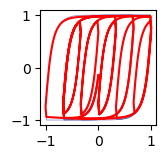

3001  --  0.0036380326
3002  --  0.0036179766
3003  --  0.0035981368
3004  --  0.003582499
3005  --  0.0035744205
3006  --  0.003575911
3007  --  0.0035869535
3008  --  0.0036062126
3009  --  0.0036311408
3010  --  0.0036582705
3011  --  0.0036835722
3012  --  0.0037028005
3013  --  0.0037129596
3014  --  0.0037124788
3015  --  0.0037014072
3016  --  0.0036815135
3017  --  0.003655947
3018  --  0.0036288213
3019  --  0.0036041592
3020  --  0.0035854646
3021  --  0.0035752594
3022  --  0.003574712
3023  --  0.0035829719
3024  --  0.0035974123
3025  --  0.003613835
3026  --  0.0036273755
3027  --  0.0036339639
3028  --  0.0036304682
3029  --  0.003617326
3030  --  0.0035967263
3031  --  0.0035728824
3032  --  0.0035507295
3033  --  0.0035349166
3034  --  0.0035289854
3035  --  0.0035342958
3036  --  0.0035503511
3037  --  0.0035752205
3038  --  0.0036053697
3039  --  0.0036364433
3040  --  0.0036635944
3041  --  0.0036827896
3042  --  0.0036906502
3043  --  0.0036859512
3044  --  0.00366

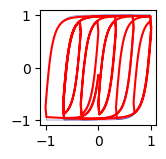

3051  --  0.003540426
3052  --  0.0035508631
3053  --  0.0035654344
3054  --  0.003579185
3055  --  0.003587737
3056  --  0.0035877018
3057  --  0.0035777555
3058  --  0.0035597307
3059  --  0.0035372484
3060  --  0.0035148677
3061  --  0.0034973
3062  --  0.003488119
3063  --  0.0034894596
3064  --  0.0035015112
3065  --  0.0035228033
3066  --  0.0035505488
3067  --  0.003580864
3068  --  0.0036091479
3069  --  0.003631224
3070  --  0.0036435872
3071  --  0.0036444678
3072  --  0.0036340256
3073  --  0.0036143004
3074  --  0.0035887212
3075  --  0.0035613098
3076  --  0.0035360106
3077  --  0.0035161593
3078  --  0.0035041326
3079  --  0.0035006783
3080  --  0.0035047748
3081  --  0.003513994
3082  --  0.00352487
3083  --  0.0035330893
3084  --  0.0035355585
3085  --  0.0035305142
3086  --  0.0035178615
3087  --  0.0034999002
3088  --  0.0034803115
3089  --  0.00346296
3090  --  0.0034515099
3091  --  0.0034488197
3092  --  0.0034557285
3093  --  0.0034718602
3094  --  0.0034956501
30

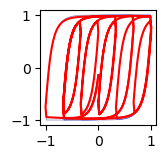

3101  --  0.0035939962
3102  --  0.003573391
3103  --  0.0035477637
3104  --  0.0035209002
3105  --  0.0034965472
3106  --  0.003477779
3107  --  0.0034667565
3108  --  0.0034640387
3109  --  0.003468562
3110  --  0.0034778295
3111  --  0.003488058
3112  --  0.0034954494
3113  --  0.0034968904
3114  --  0.0034905146
3115  --  0.003476923
3116  --  0.003458353
3117  --  0.0034384325
3118  --  0.0034210964
3119  --  0.0034103838
3120  --  0.0034088686
3121  --  0.0034177154
3122  --  0.0034366604
3123  --  0.0034639547
3124  --  0.0034965058
3125  --  0.003530203
3126  --  0.0035604916
3127  --  0.0035829265
3128  --  0.0035942954
3129  --  0.0035928385
3130  --  0.0035790643
3131  --  0.0035555256
3132  --  0.0035260164
3133  --  0.0034949672
3134  --  0.0034668595
3135  --  0.0034453436
3136  --  0.003432763
3137  --  0.0034298012
3138  --  0.0034351586
3139  --  0.003445844
3140  --  0.0034574193
3141  --  0.00346551
3142  --  0.0034664574
3143  --  0.0034586096
3144  --  0.0034423007

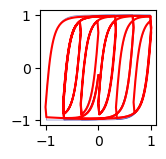

3151  --  0.0033975912
3152  --  0.0034286575
3153  --  0.0034654145
3154  --  0.0035033464
3155  --  0.0035374386
3156  --  0.0035627147
3157  --  0.0035755734
3158  --  0.0035741443
3159  --  0.0035590506
3160  --  0.0035332143
3161  --  0.0035010406
3162  --  0.0034675004
3163  --  0.0034373114
3164  --  0.0034141778
3165  --  0.0034004312
3166  --  0.003396534
3167  --  0.0034009116
3168  --  0.0034101163
3169  --  0.0034196703
3170  --  0.003425212
3171  --  0.0034236864
3172  --  0.003413777
3173  --  0.0033964114
3174  --  0.0033745838
3175  --  0.0033525578
3176  --  0.003334798
3177  --  0.0033249785
3178  --  0.0033255522
3179  --  0.0033374098
3180  --  0.0033598994
3181  --  0.0033908612
3182  --  0.0034269444
3183  --  0.0034639577
3184  --  0.003497103
3185  --  0.0035218927
3186  --  0.0035350493
3187  --  0.0035349966
3188  --  0.0035220564
3189  --  0.0034987298
3190  --  0.0034689899
3191  --  0.0034373489
3192  --  0.0034080965
3193  --  0.0033848512
3194  --  0.0033

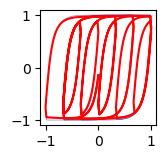

3201  --  0.0033714452
3202  --  0.0033552237
3203  --  0.0033350452
3204  --  0.0033143826
3205  --  0.003297234
3206  --  0.0032872923
3207  --  0.003287063
3208  --  0.0032974211
3209  --  0.0033181037
3210  --  0.0033475359
3211  --  0.0033828004
3212  --  0.0034200542
3213  --  0.003454851
3214  --  0.0034826791
3215  --  0.003500044
3216  --  0.0035047675
3217  --  0.0034965505
3218  --  0.0034770442
3219  --  0.003449673
3220  --  0.0034188128
3221  --  0.003388651
3222  --  0.0033629474
3223  --  0.0033445158
3224  --  0.0033346377
3225  --  0.0033328747
3226  --  0.0033367828
3227  --  0.0033427028
3228  --  0.0033467421
3229  --  0.0033460036
3230  --  0.0033383484
3231  --  0.003323672
3232  --  0.0033040037
3233  --  0.003282489
3234  --  0.0032630404
3235  --  0.0032496573
3236  --  0.0032451935
3237  --  0.0032513393
3238  --  0.0032685243
3239  --  0.0032959036
3240  --  0.0033313637
3241  --  0.0033716175
3242  --  0.0034124234
3243  --  0.00344886
3244  --  0.003476363

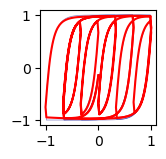

3251  --  0.0033554104
3252  --  0.0033297867
3253  --  0.0033129912
3254  --  0.003305773
3255  --  0.0033066813
3256  --  0.0033123258
3257  --  0.00331823
3258  --  0.0033203615
3259  --  0.0033157424
3260  --  0.0033028012
3261  --  0.003282803
3262  --  0.0032585454
3263  --  0.0032341601
3264  --  0.003214266
3265  --  0.0032026237
3266  --  0.003201786
3267  --  0.0032130578
3268  --  0.003236425
3269  --  0.0032705425
3270  --  0.0033126418
3271  --  0.003358787
3272  --  0.003404181
3273  --  0.0034433315
3274  --  0.0034711638
3275  --  0.0034843944
3276  --  0.003481474
3277  --  0.003463531
3278  --  0.0034341193
3279  --  0.0033981781
3280  --  0.0033610943
3281  --  0.003327852
3282  --  0.0033022275
3283  --  0.0032861424
3284  --  0.0032795575
3285  --  0.0032800238
3286  --  0.0032835589
3287  --  0.0032857347
3288  --  0.0032829095
3289  --  0.0032725947
3290  --  0.0032548436
3291  --  0.0032315336
3292  --  0.0032062728
3293  --  0.003183364
3294  --  0.0031665317
3

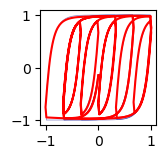

3301  --  0.003329093
3302  --  0.0033733752
3303  --  0.0034109196
3304  --  0.0034374644
3305  --  0.003449839
3306  --  0.0034468453
3307  --  0.0034298701
3308  --  0.0034020995
3309  --  0.003368111
3310  --  0.003332803
3311  --  0.0033007972
3312  --  0.0032755053
3313  --  0.0032586898
3314  --  0.0032499118
3315  --  0.0032471642
3316  --  0.0032467698
3317  --  0.0032449397
3318  --  0.003238809
3319  --  0.003226661
3320  --  0.0032085336
3321  --  0.003186213
3322  --  0.0031627773
3323  --  0.0031419278
3324  --  0.0031268264
3325  --  0.0031200517
3326  --  0.003123379
3327  --  0.003137446
3328  --  0.0031619077
3329  --  0.00319551
3330  --  0.0032360367
3331  --  0.00328043
3332  --  0.0033249236
3333  --  0.003364698
3334  --  0.0033955062
3335  --  0.0034140002
3336  --  0.0034183224
3337  --  0.0034087216
3338  --  0.0033872356
3339  --  0.0033574111
3340  --  0.0033237785
3341  --  0.0032909794
3342  --  0.003262896
3343  --  0.003241987
3344  --  0.0032288192
3345

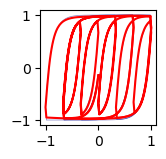

3351  --  0.0031606106
3352  --  0.0031366085
3353  --  0.0031136007
3354  --  0.0030947584
3355  --  0.0030830812
3356  --  0.0030803937
3357  --  0.0030879953
3358  --  0.0031061464
3359  --  0.0031345012
3360  --  0.0031716912
3361  --  0.0032154599
3362  --  0.0032627818
3363  --  0.003309473
3364  --  0.0033509233
3365  --  0.0033829398
3366  --  0.0034021146
3367  --  0.00340657
3368  --  0.0033965546
3369  --  0.0033741435
3370  --  0.0033430564
3371  --  0.0033080163
3372  --  0.0032739309
3373  --  0.0032447723
3374  --  0.0032227978
3375  --  0.0032083632
3376  --  0.0031999277
3377  --  0.003194654
3378  --  0.0031889935
3379  --  0.003179835
3380  --  0.0031652157
3381  --  0.0031448745
3382  --  0.0031204575
3383  --  0.0030947116
3384  --  0.003070877
3385  --  0.003051962
3386  --  0.003040215
3387  --  0.0030370941
3388  --  0.0030435552
3389  --  0.0030599963
3390  --  0.003086162
3391  --  0.003121171
3392  --  0.0031632227
3393  --  0.003209772
3394  --  0.0032575156

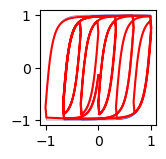

3401  --  0.0033489037
3402  --  0.0033181724
3403  --  0.0032846627
3404  --  0.0032525968
3405  --  0.003225038
3406  --  0.0032032633
3407  --  0.003186691
3408  --  0.0031733483
3409  --  0.0031609677
3410  --  0.0031471185
3411  --  0.00312997
3412  --  0.0031090903
3413  --  0.003085504
3414  --  0.003061388
3415  --  0.003038841
3416  --  0.0030200763
3417  --  0.0030066408
3418  --  0.002999741
3419  --  0.0030001146
3420  --  0.0030082802
3421  --  0.0030243504
3422  --  0.003048141
3423  --  0.0030788924
3424  --  0.0031154142
3425  --  0.0031560238
3426  --  0.0031985245
3427  --  0.0032402663
3428  --  0.0032784324
3429  --  0.003310123
3430  --  0.0033327364
3431  --  0.0033443451
3432  --  0.0033441174
3433  --  0.0033326994
3434  --  0.0033119323
3435  --  0.0032848746
3436  --  0.0032549226
3437  --  0.0032253843
3438  --  0.0031984088
3439  --  0.0031748423
3440  --  0.003154183
3441  --  0.0031355245
3442  --  0.0031172559
3443  --  0.0030979565
3444  --  0.0030769152

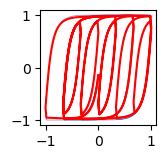

3451  --  0.0029629897
3452  --  0.0029636554
3453  --  0.0029705844
3454  --  0.0029839354
3455  --  0.0030037216
3456  --  0.0030296757
3457  --  0.0030612792
3458  --  0.0030975803
3459  --  0.003137381
3460  --  0.0031789679
3461  --  0.0032203442
3462  --  0.0032591608
3463  --  0.003292669
3464  --  0.0033183307
3465  --  0.0033337066
3466  --  0.00333744
3467  --  0.0033292472
3468  --  0.0033104317
3469  --  0.003283619
3470  --  0.0032521188
3471  --  0.0032192331
3472  --  0.0031875202
3473  --  0.003158586
3474  --  0.0031323158
3475  --  0.0031080258
3476  --  0.0030847718
3477  --  0.0030617528
3478  --  0.0030385922
3479  --  0.0030159277
3480  --  0.0029943637
3481  --  0.0029746108
3482  --  0.0029574307
3483  --  0.0029435395
3484  --  0.0029333336
3485  --  0.0029271757
3486  --  0.002925353
3487  --  0.002928209
3488  --  0.00293607
3489  --  0.0029489566
3490  --  0.0029668778
3491  --  0.002989624
3492  --  0.0030170227
3493  --  0.003048777
3494  --  0.0030844545


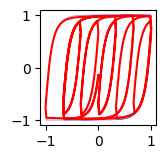

3501  --  0.0033440345
3502  --  0.0033528134
3503  --  0.0033471745
3504  --  0.0033277802
3505  --  0.003296911
3506  --  0.0032581787
3507  --  0.003215662
3508  --  0.003173351
3509  --  0.0031333964
3510  --  0.003097012
3511  --  0.0030645833
3512  --  0.0030357696
3513  --  0.0030100187
3514  --  0.0029870647
3515  --  0.0029667304
3516  --  0.0029489426
3517  --  0.0029336512
3518  --  0.0029208972
3519  --  0.0029105984
3520  --  0.002902677
3521  --  0.002897154
3522  --  0.002894054
3523  --  0.002893692
3524  --  0.0028961387
3525  --  0.0029015278
3526  --  0.0029098983
3527  --  0.0029213072
3528  --  0.0029359008
3529  --  0.0029537932
3530  --  0.0029753505
3531  --  0.0030009632
3532  --  0.0030311262
3533  --  0.0030664206
3534  --  0.0031070677
3535  --  0.0031525656
3536  --  0.0032014677
3537  --  0.0032509998
3538  --  0.0032973974
3539  --  0.003335802
3540  --  0.0033613674
3541  --  0.0033701889
3542  --  0.0033605276
3543  --  0.0033330612
3544  --  0.00329107

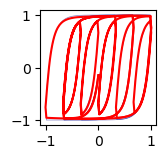

3551  --  0.0029749854
3552  --  0.0029520802
3553  --  0.0029339925
3554  --  0.0029195275
3555  --  0.0029080189
3556  --  0.0028987417
3557  --  0.002891275
3558  --  0.002885224
3559  --  0.002880214
3560  --  0.002876008
3561  --  0.0028726282
3562  --  0.0028701895
3563  --  0.0028689322
3564  --  0.0028691352
3565  --  0.0028709413
3566  --  0.00287464
3567  --  0.0028805474
3568  --  0.0028888609
3569  --  0.0029000025
3570  --  0.0029145451
3571  --  0.0029331618
3572  --  0.0029569184
3573  --  0.0029870847
3574  --  0.0030249094
3575  --  0.0030713913
3576  --  0.0031265637
3577  --  0.0031892564
3578  --  0.0032562949
3579  --  0.0033223901
3580  --  0.0033801757
3581  --  0.0034214368
3582  --  0.003438802
3583  --  0.0034280922
3584  --  0.0033899571
3585  --  0.0033304032
3586  --  0.0032582674
3587  --  0.003183318
3588  --  0.0031137671
3589  --  0.003054986
3590  --  0.0030094448
3591  --  0.0029762632
3592  --  0.0029533294
3593  --  0.0029382964
3594  --  0.00292817

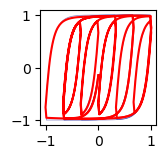

3601  --  0.0028794778
3602  --  0.0028715436
3603  --  0.0028644307
3604  --  0.0028591002
3605  --  0.0028563777
3606  --  0.0028570055
3607  --  0.0028615799
3608  --  0.0028702447
3609  --  0.00288292
3610  --  0.0028994507
3611  --  0.002919274
3612  --  0.0029425013
3613  --  0.002969336
3614  --  0.0030001155
3615  --  0.0030352352
3616  --  0.0030742935
3617  --  0.0031157064
3618  --  0.0031567703
3619  --  0.0031937426
3620  --  0.0032221463
3621  --  0.0032378992
3622  --  0.0032383876
3623  --  0.003223147
3624  --  0.003194197
3625  --  0.0031550366
3626  --  0.0031096812
3627  --  0.003062773
3628  --  0.0030174572
3629  --  0.0029756965
3630  --  0.0029385218
3631  --  0.002906214
3632  --  0.0028787768
3633  --  0.0028556348
3634  --  0.0028364474
3635  --  0.0028208469
3636  --  0.0028085678
3637  --  0.0027991517
3638  --  0.0027922397
3639  --  0.0027875006
3640  --  0.002784678
3641  --  0.002783623
3642  --  0.0027843078
3643  --  0.0027867209
3644  --  0.002790794

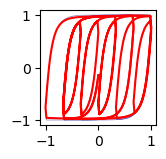

3651  --  0.002875729
3652  --  0.0029001064
3653  --  0.0029288693
3654  --  0.0029621723
3655  --  0.002999603
3656  --  0.0030400732
3657  --  0.0030816128
3658  --  0.0031214508
3659  --  0.0031561179
3660  --  0.003181881
3661  --  0.003195306
3662  --  0.0031942609
3663  --  0.0031781604
3664  --  0.0031482615
3665  --  0.0031078358
3666  --  0.0030609265
3667  --  0.0030120253
3668  --  0.0029647453
3669  --  0.002922125
3670  --  0.0028857742
3671  --  0.0028566245
3672  --  0.0028350046
3673  --  0.0028205058
3674  --  0.0028124051
3675  --  0.0028099013
3676  --  0.0028121294
3677  --  0.0028182352
3678  --  0.0028271917
3679  --  0.0028378458
3680  --  0.0028490464
3681  --  0.0028595903
3682  --  0.0028684088
3683  --  0.0028746203
3684  --  0.0028775502
3685  --  0.0028769297
3686  --  0.002872655
3687  --  0.0028651722
3688  --  0.002855361
3689  --  0.0028445167
3690  --  0.0028342823
3691  --  0.0028265729
3692  --  0.0028231726
3693  --  0.0028258425
3694  --  0.002836

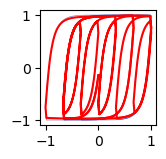

3701  --  0.003270553
3702  --  0.0033818197
3703  --  0.0034799802
3704  --  0.003545089
3705  --  0.0035603647
3706  --  0.0035190037
3707  --  0.00342879
3708  --  0.003309536
3709  --  0.0031856077
3710  --  0.0030772553
3711  --  0.0029952521
3712  --  0.0029403893
3713  --  0.002906481
3714  --  0.002884805
3715  --  0.0028677438
3716  --  0.0028502718
3717  --  0.0028306837
3718  --  0.0028093818
3719  --  0.0027880177
3720  --  0.002768209
3721  --  0.002751363
3722  --  0.0027383105
3723  --  0.002729636
3724  --  0.0027255546
3725  --  0.002726347
3726  --  0.0027316536
3727  --  0.0027406479
3728  --  0.002752151
3729  --  0.002764893
3730  --  0.002777768
3731  --  0.0027898927
3732  --  0.002800679
3733  --  0.0028100586
3734  --  0.0028178766
3735  --  0.0028242418
3736  --  0.0028292611
3737  --  0.0028328758
3738  --  0.0028350644
3739  --  0.0028357669
3740  --  0.0028349713
3741  --  0.0028326751
3742  --  0.0028288413
3743  --  0.0028234816
3744  --  0.002816337
3745

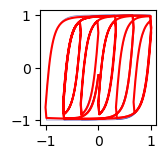

3751  --  0.0027394497
3752  --  0.00273152
3753  --  0.0027262648
3754  --  0.0027241122
3755  --  0.0027254263
3756  --  0.002730397
3757  --  0.0027390863
3758  --  0.0027514563
3759  --  0.00276736
3760  --  0.0027864897
3761  --  0.0028083362
3762  --  0.002832342
3763  --  0.002857658
3764  --  0.0028830958
3765  --  0.0029072477
3766  --  0.0029285317
3767  --  0.0029452571
3768  --  0.0029558062
3769  --  0.0029588607
3770  --  0.0029537925
3771  --  0.0029407563
3772  --  0.002920824
3773  --  0.0028957366
3774  --  0.00286783
3775  --  0.0028393513
3776  --  0.0028124403
3777  --  0.0027886287
3778  --  0.0027690332
3779  --  0.0027539684
3780  --  0.0027432735
3781  --  0.002736537
3782  --  0.0027334078
3783  --  0.0027335333
3784  --  0.0027368322
3785  --  0.0027428344
3786  --  0.0027512072
3787  --  0.002761502
3788  --  0.0027731482
3789  --  0.002785375
3790  --  0.0027974288
3791  --  0.002808526
3792  --  0.0028177416
3793  --  0.002824173
3794  --  0.0028268823
379

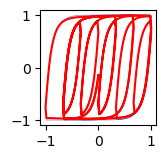

3801  --  0.002738758
3802  --  0.0027239323
3803  --  0.0027158533
3804  --  0.0027180666
3805  --  0.0027341724
3806  --  0.0027675068
3807  --  0.0028212194
3808  --  0.0028972162
3809  --  0.0029954028
3810  --  0.0031121178
3811  --  0.003238342
3812  --  0.0033587017
3813  --  0.0034530861
3814  --  0.00350116
3815  --  0.0034902182
3816  --  0.0034204836
3817  --  0.003306473
3818  --  0.0031705608
3819  --  0.0030353153
3820  --  0.0029174078
3821  --  0.0028256732
3822  --  0.0027615833
3823  --  0.0027221076
3824  --  0.002702193
3825  --  0.0026959605
3826  --  0.0026983328
3827  --  0.0027047587
3828  --  0.0027117692
3829  --  0.0027167157
3830  --  0.0027176568
3831  --  0.0027139257
3832  --  0.0027052942
3833  --  0.0026926517
3834  --  0.002677718
3835  --  0.0026626873
3836  --  0.0026502681
3837  --  0.002643119
3838  --  0.0026431743
3839  --  0.0026515324
3840  --  0.0026680694
3841  --  0.0026912594
3842  --  0.0027184659
3843  --  0.0027460854
3844  --  0.0027708

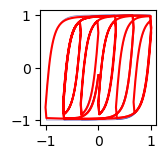

3851  --  0.002788158
3852  --  0.0027787064
3853  --  0.0027694602
3854  --  0.002761043
3855  --  0.0027533253
3856  --  0.0027455478
3857  --  0.0027364304
3858  --  0.0027248596
3859  --  0.0027098535
3860  --  0.0026915944
3861  --  0.0026711882
3862  --  0.0026500719
3863  --  0.0026302638
3864  --  0.002613645
3865  --  0.002601549
3866  --  0.0025950002
3867  --  0.0025946246
3868  --  0.0026007725
3869  --  0.002613555
3870  --  0.002632774
3871  --  0.0026579867
3872  --  0.002688344
3873  --  0.0027227676
3874  --  0.0027599148
3875  --  0.0027981095
3876  --  0.0028355024
3877  --  0.002870088
3878  --  0.0028993555
3879  --  0.0029206702
3880  --  0.00293162
3881  --  0.0029306274
3882  --  0.0029173712
3883  --  0.0028930656
3884  --  0.0028605352
3885  --  0.0028233586
3886  --  0.0027853267
3887  --  0.0027494426
3888  --  0.0027177448
3889  --  0.0026907043
3890  --  0.002668127
3891  --  0.0026493182
3892  --  0.0026341423
3893  --  0.0026223906
3894  --  0.0026137969

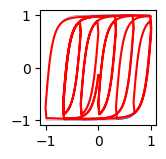

3901  --  0.0026167976
3902  --  0.0026211306
3903  --  0.002624784
3904  --  0.00262709
3905  --  0.0026274596
3906  --  0.002625504
3907  --  0.002620973
3908  --  0.0026140118
3909  --  0.0026052902
3910  --  0.0025957383
3911  --  0.002586668
3912  --  0.002579468
3913  --  0.002575824
3914  --  0.0025774909
3915  --  0.002586109
3916  --  0.0026034063
3917  --  0.0026312126
3918  --  0.0026714737
3919  --  0.0027261856
3920  --  0.0027970085
3921  --  0.0028845968
3922  --  0.0029875014
3923  --  0.0031005826
3924  --  0.0032139306
3925  --  0.003312794
3926  --  0.0033794898
3927  --  0.0033989064
3928  --  0.003363768
3929  --  0.003278476
3930  --  0.003157873
3931  --  0.0030220635
3932  --  0.0028900325
3933  --  0.0027757746
3934  --  0.0026870922
3935  --  0.0026267753
3936  --  0.0025943508
3937  --  0.0025871624
3938  --  0.0026010007
3939  --  0.0026299427
3940  --  0.0026670583
3941  --  0.0027045973
3942  --  0.0027353282
3943  --  0.0027532352
3944  --  0.002755413
39

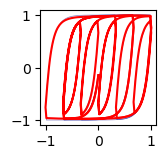

3951  --  0.0026050294
3952  --  0.0026161787
3953  --  0.002638572
3954  --  0.0026664757
3955  --  0.002692526
3956  --  0.0027100495
3957  --  0.0027153625
3958  --  0.0027092746
3959  --  0.0026953572
3960  --  0.0026782204
3961  --  0.0026618936
3962  --  0.0026485214
3963  --  0.0026388327
3964  --  0.0026326044
3965  --  0.002629009
3966  --  0.002626721
3967  --  0.0026239995
3968  --  0.0026191394
3969  --  0.0026107416
3970  --  0.0025985844
3971  --  0.0025831477
3972  --  0.0025662102
3973  --  0.0025498178
3974  --  0.0025359392
3975  --  0.002526138
3976  --  0.0025214353
3977  --  0.0025223142
3978  --  0.0025288016
3979  --  0.002540558
3980  --  0.0025569035
3981  --  0.002576867
3982  --  0.0025992563
3983  --  0.0026227282
3984  --  0.0026458853
3985  --  0.0026672317
3986  --  0.0026855373
3987  --  0.0026997111
3988  --  0.0027087033
3989  --  0.0027119422
3990  --  0.0027091461
3991  --  0.002700497
3992  --  0.0026867362
3993  --  0.00266907
3994  --  0.002648870

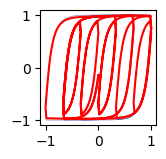

4001  --  0.0025196942
4002  --  0.0025073467
4003  --  0.0024967894
4004  --  0.0024881526
4005  --  0.0024815118
4006  --  0.0024769122
4007  --  0.0024743353
4008  --  0.0024737047
4009  --  0.0024748407
4010  --  0.0024774955
4011  --  0.002481245
4012  --  0.002485555
4013  --  0.002489858
4014  --  0.0024935738
4015  --  0.0024961606
4016  --  0.0024971894
4017  --  0.002496438
4018  --  0.0024939417
4019  --  0.002490035
4020  --  0.002485343
4021  --  0.002480608
4022  --  0.0024767956
4023  --  0.0024749304
4024  --  0.0024761106
4025  --  0.0024814575
4026  --  0.0024923407
4027  --  0.0025103982
4028  --  0.0025377993
4029  --  0.002577439
4030  --  0.0026330804
4031  --  0.0027092437
4032  --  0.0028106458
4033  --  0.002940705
4034  --  0.0030981232
4035  --  0.003272461
4036  --  0.0034406614
4037  --  0.003567641
4038  --  0.003616706
4039  --  0.0035659932
4040  --  0.0034220894
4041  --  0.00321812
4042  --  0.0029982275
4043  --  0.0028001887
4044  --  0.0026468337
40

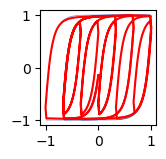

4051  --  0.0027243437
4052  --  0.0027574073
4053  --  0.0027601928
4054  --  0.0027362392
4055  --  0.0026946282
4056  --  0.0026463377
4057  --  0.0026007926
4058  --  0.0025659509
4059  --  0.002547414
4060  --  0.0025473433
4061  --  0.0025636356
4062  --  0.0025889797
4063  --  0.0026129568
4064  --  0.002625698
4065  --  0.0026215636
4066  --  0.0026010105
4067  --  0.0025696927
4068  --  0.0025353448
4069  --  0.0025043862
4070  --  0.0024804613
4071  --  0.0024648588
4072  --  0.0024568313
4073  --  0.0024546513
4074  --  0.0024560806
4075  --  0.0024586814
4076  --  0.0024602695
4077  --  0.0024594055
4078  --  0.002455636
4079  --  0.0024494252
4080  --  0.0024418912
4081  --  0.0024345762
4082  --  0.0024288474
4083  --  0.0024259037
4084  --  0.0024265833
4085  --  0.0024313207
4086  --  0.0024401601
4087  --  0.0024528033
4088  --  0.002468633
4089  --  0.0024867884
4090  --  0.0025063208
4091  --  0.002526079
4092  --  0.00254489
4093  --  0.002561759
4094  --  0.0025758

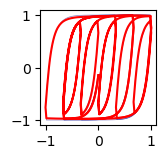

4101  --  0.0025624451
4102  --  0.0025472355
4103  --  0.0025306477
4104  --  0.0025133963
4105  --  0.0024960781
4106  --  0.0024791595
4107  --  0.0024630667
4108  --  0.0024480596
4109  --  0.0024343869
4110  --  0.002422283
4111  --  0.0024119026
4112  --  0.0024033666
4113  --  0.0023967081
4114  --  0.0023918734
4115  --  0.0023887276
4116  --  0.0023870715
4117  --  0.0023866796
4118  --  0.0023872152
4119  --  0.0023883344
4120  --  0.0023896748
4121  --  0.0023909018
4122  --  0.0023917325
4123  --  0.002391931
4124  --  0.0023913526
4125  --  0.0023899637
4126  --  0.0023878396
4127  --  0.002385123
4128  --  0.0023820144
4129  --  0.0023787497
4130  --  0.0023755722
4131  --  0.002372706
4132  --  0.0023702816
4133  --  0.0023684208
4134  --  0.0023671843
4135  --  0.0023666213
4136  --  0.0023668015
4137  --  0.0023679156
4138  --  0.0023703666
4139  --  0.002374926
4140  --  0.002382904
4141  --  0.0023964124
4142  --  0.0024187267
4143  --  0.0024547214
4144  --  0.00251

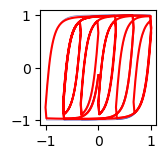

4151  --  0.0038465725
4152  --  0.0038636515
4153  --  0.0036975613
4154  --  0.0033987444
4155  --  0.003061695
4156  --  0.002771959
4157  --  0.0025745055
4158  --  0.0024751592
4159  --  0.002456549
4160  --  0.0024909629
4161  --  0.0025479093
4162  --  0.002598627
4163  --  0.0026226642
4164  --  0.002614669
4165  --  0.0025824492
4166  --  0.0025400908
4167  --  0.002500497
4168  --  0.0024712821
4169  --  0.0024556408
4170  --  0.0024538622
4171  --  0.0024645096
4172  --  0.0024839984
4173  --  0.0025058198
4174  --  0.002521627
4175  --  0.0025244888
4176  --  0.0025110154
4177  --  0.0024834343
4178  --  0.0024475132
4179  --  0.0024102894
4180  --  0.0023778002
4181  --  0.0023533995
4182  --  0.0023377938
4183  --  0.0023301928
4184  --  0.0023285472
4185  --  0.002330508
4186  --  0.0023337044
4187  --  0.0023363244
4188  --  0.0023372413
4189  --  0.002336162
4190  --  0.0023334913
4191  --  0.0023301253
4192  --  0.0023272287
4193  --  0.0023259246
4194  --  0.00232713

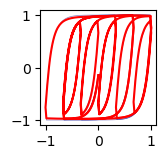

4201  --  0.0024179746
4202  --  0.0024370076
4203  --  0.0024551104
4204  --  0.0024714447
4205  --  0.00248529
4206  --  0.0024960642
4207  --  0.0025033213
4208  --  0.0025066927
4209  --  0.0025060736
4210  --  0.0025016242
4211  --  0.0024936623
4212  --  0.0024826364
4213  --  0.0024690458
4214  --  0.0024535663
4215  --  0.0024368875
4216  --  0.0024196403
4217  --  0.0024024479
4218  --  0.00238582
4219  --  0.0023701491
4220  --  0.0023557965
4221  --  0.0023430532
4222  --  0.0023320713
4223  --  0.0023229835
4224  --  0.0023158318
4225  --  0.0023105284
4226  --  0.0023069058
4227  --  0.0023047288
4228  --  0.0023037212
4229  --  0.002303516
4230  --  0.0023037975
4231  --  0.002304262
4232  --  0.0023046578
4233  --  0.0023047973
4234  --  0.002304594
4235  --  0.002304027
4236  --  0.0023031696
4237  --  0.002302167
4238  --  0.0023012294
4239  --  0.0023006338
4240  --  0.0023006394
4241  --  0.0023014918
4242  --  0.0023033726
4243  --  0.0023064031
4244  --  0.00231066

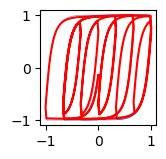

4251  --  0.002369856
4252  --  0.0023813816
4253  --  0.0023933048
4254  --  0.0024053815
4255  --  0.0024172273
4256  --  0.002428262
4257  --  0.0024376875
4258  --  0.0024443665
4259  --  0.002447172
4260  --  0.0024447974
4261  --  0.0024363156
4262  --  0.0024214974
4263  --  0.002400976
4264  --  0.002376347
4265  --  0.0023504111
4266  --  0.0023269595
4267  --  0.0023108078
4268  --  0.002308084
4269  --  0.0023266363
4270  --  0.0023770737
4271  --  0.0024734817
4272  --  0.0026329115
4273  --  0.0028711718
4274  --  0.003190154
4275  --  0.003556307
4276  --  0.0038816168
4277  --  0.004042092
4278  --  0.003952067
4279  --  0.0036399185
4280  --  0.0032306646
4281  --  0.0028540003
4282  --  0.0025791016
4283  --  0.0024142067
4284  --  0.0023359405
4285  --  0.0023142996
4286  --  0.0023241946
4287  --  0.0023469985
4288  --  0.0023695044
4289  --  0.0023828954
4290  --  0.00238302
4291  --  0.0023706062
4292  --  0.00234984
4293  --  0.0023255164
4294  --  0.0023020813
42

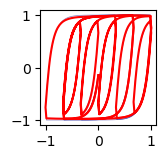

4301  --  0.002358811
4302  --  0.0023773212
4303  --  0.0023832745
4304  --  0.0023747957
4305  --  0.0023539306
4306  --  0.002325943
4307  --  0.0022970908
4308  --  0.0022722674
4309  --  0.0022543655
4310  --  0.0022444564
4311  --  0.0022419028
4312  --  0.0022448585
4313  --  0.002250702
4314  --  0.0022565448
4315  --  0.002259805
4316  --  0.0022590717
4317  --  0.0022543233
4318  --  0.002246507
4319  --  0.0022374257
4320  --  0.002229178
4321  --  0.0022237636
4322  --  0.002222761
4323  --  0.0022272118
4324  --  0.0022375123
4325  --  0.0022533808
4326  --  0.0022738967
4327  --  0.0022976068
4328  --  0.002322468
4329  --  0.0023462807
4330  --  0.00236708
4331  --  0.00238335
4332  --  0.002394004
4333  --  0.0023987857
4334  --  0.0023981612
4335  --  0.0023929477
4336  --  0.002384208
4337  --  0.0023731054
4338  --  0.0023607474
4339  --  0.002348046
4340  --  0.002335406
4341  --  0.0023229038
4342  --  0.002310293
4343  --  0.002297061
4344  --  0.0022831133
4345  

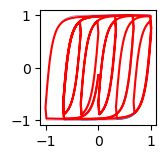

4351  --  0.002209166
4352  --  0.0022093947
4353  --  0.0022127943
4354  --  0.0022188865
4355  --  0.0022269443
4356  --  0.00223609
4357  --  0.0022452082
4358  --  0.0022532318
4359  --  0.002259353
4360  --  0.0022630182
4361  --  0.002264144
4362  --  0.0022630855
4363  --  0.0022605588
4364  --  0.0022574435
4365  --  0.0022546467
4366  --  0.002252968
4367  --  0.0022529832
4368  --  0.0022549387
4369  --  0.002258748
4370  --  0.0022640054
4371  --  0.002270077
4372  --  0.0022762096
4373  --  0.0022816204
4374  --  0.0022860237
4375  --  0.0022896796
4376  --  0.0022933413
4377  --  0.0022982392
4378  --  0.0023062238
4379  --  0.002319229
4380  --  0.002339205
4381  --  0.0023678842
4382  --  0.0024063063
4383  --  0.002454405
4384  --  0.0025102713
4385  --  0.0025698747
4386  --  0.002626531
4387  --  0.0026716958
4388  --  0.0026959563
4389  --  0.002692367
4390  --  0.002658214
4391  --  0.0025972652
4392  --  0.0025185093
4393  --  0.0024346837
4394  --  0.0023586662
43

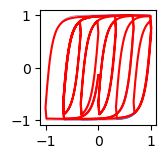

4401  --  0.002353735
4402  --  0.0023735857
4403  --  0.002388418
4404  --  0.0024010097
4405  --  0.002413707
4406  --  0.0024283244
4407  --  0.002445167
4408  --  0.0024642423
4409  --  0.0024839784
4410  --  0.0025004055
4411  --  0.0025079416
4412  --  0.0025003671
4413  --  0.0024734624
4414  --  0.0024279768
4415  --  0.0023701072
4416  --  0.002309232
4417  --  0.0022541548
4418  --  0.0022100138
4419  --  0.0021797223
4420  --  0.002162342
4421  --  0.0021556555
4422  --  0.0021567887
4423  --  0.0021630817
4424  --  0.0021723507
4425  --  0.0021831875
4426  --  0.0021949632
4427  --  0.002207749
4428  --  0.0022221953
4429  --  0.0022393775
4430  --  0.0022604086
4431  --  0.0022860758
4432  --  0.0023166793
4433  --  0.0023517308
4434  --  0.002389642
4435  --  0.0024277274
4436  --  0.0024623512
4437  --  0.0024892208
4438  --  0.002504184
4439  --  0.0025044335
4440  --  0.0024888897
4441  --  0.002458858
4442  --  0.0024178321
4443  --  0.0023704749
4444  --  0.002321752

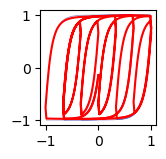

4451  --  0.0021440217
4452  --  0.0021408359
4453  --  0.0021403106
4454  --  0.0021417567
4455  --  0.0021447134
4456  --  0.0021488783
4457  --  0.0021539645
4458  --  0.00215973
4459  --  0.002165966
4460  --  0.0021723742
4461  --  0.002178574
4462  --  0.002184086
4463  --  0.0021883436
4464  --  0.0021908048
4465  --  0.0021909606
4466  --  0.0021883254
4467  --  0.0021827843
4468  --  0.002174592
4469  --  0.002164376
4470  --  0.002153158
4471  --  0.0021419835
4472  --  0.0021320072
4473  --  0.0021241785
4474  --  0.0021192876
4475  --  0.0021178634
4476  --  0.0021203056
4477  --  0.0021268644
4478  --  0.0021379013
4479  --  0.0021538907
4480  --  0.002175547
4481  --  0.0022037895
4482  --  0.002239726
4483  --  0.002284505
4484  --  0.0023389854
4485  --  0.002403071
4486  --  0.0024749113
4487  --  0.0025501589
4488  --  0.0026215473
4489  --  0.0026790448
4490  --  0.0027117922
4491  --  0.0027113238
4492  --  0.0026747978
4493  --  0.0026064515
4494  --  0.0025166278


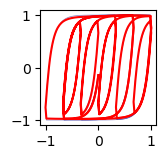

4501  --  0.0021352821
4502  --  0.0021483775
4503  --  0.0021676214
4504  --  0.0021873768
4505  --  0.0022033649
4506  --  0.00221365
4507  --  0.0022177526
4508  --  0.0022165678
4509  --  0.0022119873
4510  --  0.0022066142
4511  --  0.0022034654
4512  --  0.0022053402
4513  --  0.002213855
4514  --  0.0022285033
4515  --  0.002246059
4516  --  0.0022608633
4517  --  0.0022667095
4518  --  0.0022591054
4519  --  0.0022378406
4520  --  0.0022071716
4521  --  0.002173902
4522  --  0.0021440813
4523  --  0.0021216376
4524  --  0.0021078154
4525  --  0.0021020987
4526  --  0.0021028225
4527  --  0.0021077294
4528  --  0.0021142948
4529  --  0.0021202285
4530  --  0.002123937
4531  --  0.0021249412
4532  --  0.0021238797
4533  --  0.0021223258
4534  --  0.002122278
4535  --  0.0021259903
4536  --  0.0021353844
4537  --  0.0021518313
4538  --  0.002176017
4539  --  0.0022077165
4540  --  0.0022456916
4541  --  0.002287426
4542  --  0.0023293176
4543  --  0.0023669174
4544  --  0.00239551

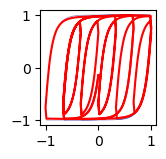

4551  --  0.0022216162
4552  --  0.002178997
4553  --  0.0021438918
4554  --  0.0021172697
4555  --  0.002098652
4556  --  0.0020865372
4557  --  0.0020793118
4558  --  0.002075696
4559  --  0.002074966
4560  --  0.0020768768
4561  --  0.002081431
4562  --  0.0020885563
4563  --  0.0020979797
4564  --  0.0021093949
4565  --  0.0021222616
4566  --  0.0021356908
4567  --  0.0021485358
4568  --  0.0021594318
4569  --  0.0021668868
4570  --  0.0021694556
4571  --  0.002166296
4572  --  0.002157234
4573  --  0.00214289
4574  --  0.0021246693
4575  --  0.002104306
4576  --  0.002083795
4577  --  0.0020648916
4578  --  0.0020489541
4579  --  0.0020367557
4580  --  0.0020286685
4581  --  0.0020248098
4582  --  0.0020251796
4583  --  0.002029919
4584  --  0.0020394241
4585  --  0.0020545537
4586  --  0.0020767897
4587  --  0.0021082808
4588  --  0.002151813
4589  --  0.0022104832
4590  --  0.0022870097
4591  --  0.002382347
4592  --  0.0024934013
4593  --  0.0026112609
4594  --  0.0027196433
45

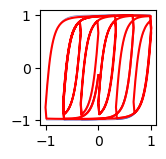

4601  --  0.0022799866
4602  --  0.0021779826
4603  --  0.0021110044
4604  --  0.0020771425
4605  --  0.0020696968
4606  --  0.0020792775
4607  --  0.0020961715
4608  --  0.0021120196
4609  --  0.0021213514
4610  --  0.0021226192
4611  --  0.0021174797
4612  --  0.0021086086
4613  --  0.0020990046
4614  --  0.0020913656
4615  --  0.0020880322
4616  --  0.002090794
4617  --  0.002099894
4618  --  0.002113302
4619  --  0.0021272048
4620  --  0.0021368696
4621  --  0.0021378468
4622  --  0.002128322
4623  --  0.0021097872
4624  --  0.0020857283
4625  --  0.002060698
4626  --  0.002038537
4627  --  0.0020216038
4628  --  0.0020106605
4629  --  0.0020052318
4630  --  0.0020040094
4631  --  0.0020053496
4632  --  0.002007589
4633  --  0.0020093508
4634  --  0.002009789
4635  --  0.0020087871
4636  --  0.002006851
4637  --  0.0020051473
4638  --  0.002005112
4639  --  0.0020082027
4640  --  0.0020157006
4641  --  0.0020285947
4642  --  0.0020474393
4643  --  0.002072249
4644  --  0.0021024481

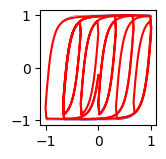

4651  --  0.002283765
4652  --  0.0022741635
4653  --  0.0022530346
4654  --  0.002222924
4655  --  0.0021873214
4656  --  0.0021499381
4657  --  0.0021140168
4658  --  0.0020817423
4659  --  0.0020540594
4660  --  0.0020311582
4661  --  0.0020125795
4662  --  0.0019976702
4663  --  0.0019859602
4664  --  0.001977344
4665  --  0.0019720073
4666  --  0.0019701899
4667  --  0.0019720418
4668  --  0.001977514
4669  --  0.0019864012
4670  --  0.0019981645
4671  --  0.0020119348
4672  --  0.0020264846
4673  --  0.0020402572
4674  --  0.0020516363
4675  --  0.0020592548
4676  --  0.0020620157
4677  --  0.0020595507
4678  --  0.0020522794
4679  --  0.0020413457
4680  --  0.0020280946
4681  --  0.0020140936
4682  --  0.002000642
4683  --  0.0019886657
4684  --  0.0019786118
4685  --  0.001970446
4686  --  0.0019636662
4687  --  0.0019579362
4688  --  0.0019526383
4689  --  0.0019473414
4690  --  0.0019419766
4691  --  0.0019370118
4692  --  0.0019336024
4693  --  0.0019337728
4694  --  0.00194

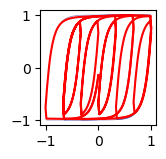

4701  --  0.0027271109
4702  --  0.0029841012
4703  --  0.0031953973
4704  --  0.0032847093
4705  --  0.003204672
4706  --  0.002975392
4707  --  0.0026776758
4708  --  0.0024020441
4709  --  0.002204565
4710  --  0.0020969794
4711  --  0.0020603884
4712  --  0.0020637817
4713  --  0.0020770913
4714  --  0.0020796438
4715  --  0.0020650155
4716  --  0.0020381105
4717  --  0.0020095352
4718  --  0.0019871346
4719  --  0.001974337
4720  --  0.001971004
4721  --  0.001975073
4722  --  0.0019837387
4723  --  0.001994092
4724  --  0.0020029433
4725  --  0.002008212
4726  --  0.0020073494
4727  --  0.001999847
4728  --  0.001986815
4729  --  0.0019703587
4730  --  0.0019531214
4731  --  0.0019370121
4732  --  0.0019240066
4733  --  0.0019146223
4734  --  0.001908619
4735  --  0.0019053359
4736  --  0.0019038875
4737  --  0.0019033733
4738  --  0.0019030841
4739  --  0.0019025694
4740  --  0.0019017281
4741  --  0.001900773
4742  --  0.001900168
4743  --  0.001900496
4744  --  0.0019023474
47

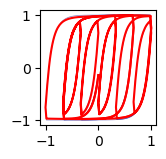

4751  --  0.0019778002
4752  --  0.001994743
4753  --  0.0020114344
4754  --  0.0020270895
4755  --  0.002040887
4756  --  0.0020520992
4757  --  0.00206009
4758  --  0.0020644544
4759  --  0.0020649978
4760  --  0.002061756
4761  --  0.002054997
4762  --  0.0020451462
4763  --  0.0020328094
4764  --  0.0020185763
4765  --  0.002003148
4766  --  0.0019871613
4767  --  0.0019711498
4768  --  0.0019556365
4769  --  0.0019410674
4770  --  0.0019278526
4771  --  0.0019163
4772  --  0.0019066229
4773  --  0.0018989283
4774  --  0.0018932341
4775  --  0.0018894367
4776  --  0.0018873512
4777  --  0.001886706
4778  --  0.0018871729
4779  --  0.0018883504
4780  --  0.0018898122
4781  --  0.0018911754
4782  --  0.0018921151
4783  --  0.0018924454
4784  --  0.0018921212
4785  --  0.001891266
4786  --  0.0018901674
4787  --  0.0018892424
4788  --  0.0018889727
4789  --  0.0018898156
4790  --  0.0018922288
4791  --  0.0018966222
4792  --  0.001903317
4793  --  0.0019125424
4794  --  0.0019244592
4

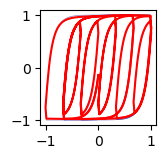

4801  --  0.0020712211
4802  --  0.0020931235
4803  --  0.002110697
4804  --  0.0021217403
4805  --  0.002124318
4806  --  0.0021170625
4807  --  0.0020997305
4808  --  0.0020733709
4809  --  0.0020402507
4810  --  0.0020034558
4811  --  0.0019663193
4812  --  0.0019333244
4813  --  0.0019087212
4814  --  0.001896797
4815  --  0.0019026643
4816  --  0.0019327613
4817  --  0.0019944515
4818  --  0.0020959694
4819  --  0.0022438832
4820  --  0.0024376165
4821  --  0.0026607146
4822  --  0.002872284
4823  --  0.0030118886
4824  --  0.003025353
4825  --  0.0028998614
4826  --  0.002677553
4827  --  0.0024293077
4828  --  0.0022154893
4829  --  0.002064705
4830  --  0.0019769587
4831  --  0.0019367648
4832  --  0.0019242092
4833  --  0.0019221316
4834  --  0.0019187732
4835  --  0.0019090079
4836  --  0.0018933049
4837  --  0.0018753819
4838  --  0.0018594105
4839  --  0.0018483866
4840  --  0.0018439122
4841  --  0.0018464018
4842  --  0.0018555812
4843  --  0.0018702784
4844  --  0.001888

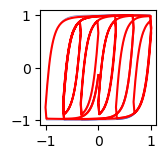

4851  --  0.0018734296
4852  --  0.0018546253
4853  --  0.0018392887
4854  --  0.001828596
4855  --  0.0018224368
4856  --  0.0018200156
4857  --  0.0018199063
4858  --  0.0018205768
4859  --  0.0018206154
4860  --  0.0018191524
4861  --  0.0018160687
4862  --  0.001811986
4863  --  0.0018080438
4864  --  0.0018056027
4865  --  0.0018060182
4866  --  0.0018104097
4867  --  0.0018194962
4868  --  0.0018334986
4869  --  0.0018521643
4870  --  0.0018745823
4871  --  0.0018995171
4872  --  0.0019251996
4873  --  0.001949746
4874  --  0.0019713242
4875  --  0.0019884566
4876  --  0.002000001
4877  --  0.0020055103
4878  --  0.0020050118
4879  --  0.0019988636
4880  --  0.0019879567
4881  --  0.0019733396
4882  --  0.00195617
4883  --  0.0019375172
4884  --  0.0019182101
4885  --  0.0018987227
4886  --  0.0018794808
4887  --  0.0018608695
4888  --  0.0018433686
4889  --  0.0018275366
4890  --  0.0018140217
4891  --  0.0018034694
4892  --  0.0017963467
4893  --  0.001792823
4894  --  0.001792

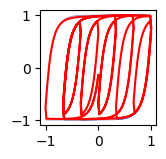

4901  --  0.0018274188
4902  --  0.001825995
4903  --  0.001821599
4904  --  0.0018149397
4905  --  0.001807
4906  --  0.0017988448
4907  --  0.0017912941
4908  --  0.0017851145
4909  --  0.0017805971
4910  --  0.001777674
4911  --  0.0017759957
4912  --  0.0017750514
4913  --  0.0017743196
4914  --  0.0017733956
4915  --  0.001772149
4916  --  0.0017708045
4917  --  0.001770046
4918  --  0.0017709844
4919  --  0.0017752007
4920  --  0.0017847845
4921  --  0.0018024424
4922  --  0.0018315195
4923  --  0.0018763385
4924  --  0.0019421421
4925  --  0.0020347366
4926  --  0.0021591855
4927  --  0.0023168304
4928  --  0.0024988723
4929  --  0.0026819701
4930  --  0.0028240746
4931  --  0.002875896
4932  --  0.0028077664
4933  --  0.002633211
4934  --  0.0024059871
4935  --  0.0021899324
4936  --  0.002028493
4937  --  0.0019342696
4938  --  0.001895065
4939  --  0.0018875521
4940  --  0.0018898925
4941  --  0.0018885243
4942  --  0.0018802148
4943  --  0.0018691043
4944  --  0.0018610741
4

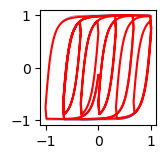

4951  --  0.0019142686
4952  --  0.0019057688
4953  --  0.0018886923
4954  --  0.0018644262
4955  --  0.0018362823
4956  --  0.0018078567
4957  --  0.0017826052
4958  --  0.0017623132
4959  --  0.001747479
4960  --  0.0017376906
4961  --  0.0017319198
4962  --  0.0017290107
4963  --  0.0017277144
4964  --  0.0017270541
4965  --  0.00172644
4966  --  0.0017257408
4967  --  0.0017252493
4968  --  0.001725567
4969  --  0.0017274527
4970  --  0.0017316908
4971  --  0.0017389712
4972  --  0.0017497902
4973  --  0.0017643753
4974  --  0.0017826841
4975  --  0.0018043235
4976  --  0.0018285891
4977  --  0.0018544574
4978  --  0.0018805666
4979  --  0.0019052862
4980  --  0.0019268256
4981  --  0.0019433184
4982  --  0.0019532423
4983  --  0.0019555218
4984  --  0.0019498977
4985  --  0.0019368496
4986  --  0.0019175868
4987  --  0.0018938397
4988  --  0.001867575
4989  --  0.0018406427
4990  --  0.0018145733
4991  --  0.0017904672
4992  --  0.0017689491
4993  --  0.0017503572
4994  --  0.0017

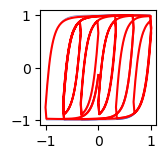

In [11]:
learningRate = 1.e-4
optimizer = optim.NAdam(TANNnet.parameters(),
                        lr=learningRate)
loss_hist = []
loss_fn = torch.nn.MSELoss()

for itr in range(1, niters + 1):
    if itr % test_freq==0:
        fig, ax = plt.subplots(figsize=(1.5,1.5))
    loss_value = 0.
    loss=0.
    for i in range(ntrain):
        
        # Make predictions and backpropagate loss for each path
        
        pred = TANNnet.forward(input_tv[i,:,0])
        
        # loss on evolution equation
        loss = loss_fn(pred[:,0],output_tv[i,:,0,0])
        # loss on energy
        loss += loss_fn(pred[:,1],output_tv[i,:,0,1])
        # loss on stress
        loss += loss_fn(pred[:,2],output_tv[i,:,0,2])
        # loss on dissipation rate
        loss += loss_fn(pred[:,3],output_tv[i,:,0,3])

        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        
        loss_value+=loss.item() 
        
        if itr % test_freq==0:
            # Plot stress target values and predictions
            ax.plot(strain_t_tv[i,:,0],output_tv[i,:,0,2].cpu().numpy(),color='darkblue',alpha=0.5,linestyle='-',linewidth=0.5)
            ax.plot(strain_t_tv[i,:,0],pred.detach()[:,2].cpu().numpy(),color='red')
    
    loss_hist.append(loss_value)
    print(itr,' -- ',np.float32(loss_value))
        
    if itr % test_freq==0:
        plt.show()

#### Plot loss history

[]

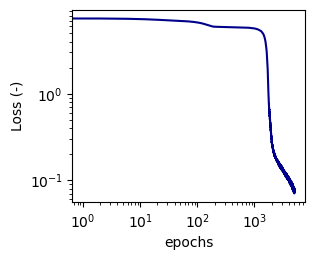

In [12]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.loglog(loss_hist,color='darkblue')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss (-)')
plt.plot()

### Model at inference (test set)

In [13]:
# Make predictions for test data
for i in range(ntest):        
    if i == 0:
        pred_test = TANNnet.forward(input_test[i,:,0])
        pred_test = pred_test[None,:,:]
    else:
        pred_test_i = TANNnet.forward(input_test[i,:,0])
        pred_test = torch.cat((pred_test,pred_test_i[None,:,:]),0)
        
pred_test = pred_test.cpu().detach()

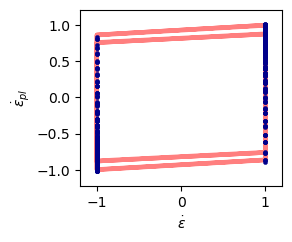

In [14]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(dstrain_test[i,:,:,0],dstrain_pl_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(dstrain_test[i,:,0],pred_test[i,:,0],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$\dot{\\varepsilon}_{pl}$')
ax.set_xlabel('$\dot{\\varepsilon}$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()

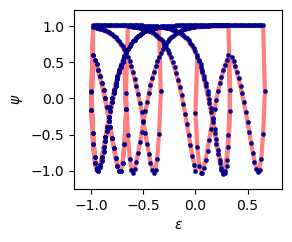

In [15]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(strain_t_test[i,:,:,0],energy_tdt_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(strain_t_test[i,:,0],pred_test[i,:,1],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$\psi$')
ax.set_xlabel('$\\varepsilon$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()

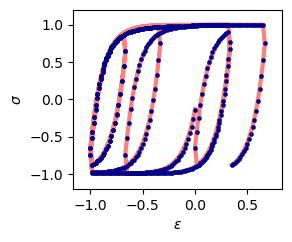

In [16]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(strain_t_test[i,:,:,0],stress_tdt_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(strain_t_test[i,:,0],pred_test[i,:,2],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$\sigma$')
ax.set_xlabel('$\\varepsilon$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()

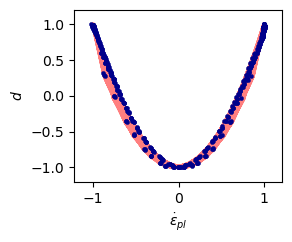

In [17]:
fig, ax = plt.subplots(figsize=(3.,2.5))
ax.margins(x=0.1, y = 0.1)
for i in np.arange(1):
    ax.plot(dstrain_pl_test[i,:,0,0],dissipation_rate_tdt_test[i,:,0,0],color='red',
            alpha=0.5,linewidth=3,label='ref')
    ax.plot(pred_test[i,:,0],pred_test[i,:,3],alpha=1,linewidth=0,markersize=3,color='darkblue',
            marker='o',label='pred',markeredgewidth=0.3, linestyle='-')
ax.set_ylabel('$d$')
ax.set_xlabel('$\dot{\\varepsilon}_{pl}$')
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.5)
plt.show()